#### Farouk Khlifi and Adrien Lemercier, Ecole Polytechnique, May 2020

# Project Random Numerical Simulations: Population dynamics 

## Implementation of Interacting Particle Systems techniques (Adrien Lemercier)

### To begin

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import time

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]

For confidence intervals

In [3]:
"Given an array X of independant realizations of an estimator, and given a confidence level gamma,"
"the function confidence returns a confidence interval of the estimated quantity"

def confidence(X, gamma) :
    l = len(X)
    m = np.mean(X)
    s = np.std(X)
    q = sps.t.ppf((1+gamma)/2, l-1)   #quantile of Student's t-distribution
    dev = (q*s)/np.sqrt(l)
    return (m, [m - dev, m+dev])

### I. Geometric reproduction law

Each individual has a random number of children given by a geometric distribution translated so that 0 can be reached. More precisely, $\mathbb{P}(X=k)=\frac{1}{m+1}(\frac{m}{m+1})^{k}$ where $m$ is a parameter which gives the expected value of the distribution.

If we denote by $X_n$ the population at generation $n$, then the random process $(X_n)_{n \in N}$ is a Markov Chain, whose transition probability is clearly given by markov_bis() (see below). In fact, markov() gives the same transition probability and has a faster asymptotic runtime (ie. for $k$ big). This is a classic property. See the function check() for empirical evidence.

Definition of the problem's parameters (can of course be modified later)

In [4]:
m = .7             #average number of children for an individual
n = 15             #number of generation
pop = 1            #size of the initial population (at generation 0) 

Definition of simulation parameters

In [5]:
M = int(1e2)   # number of interacting particles

Definition of the Markov chain of the problem (translated geometric distribution so that 0 can be reached)

In [6]:
def markov(k) :
    if k==0 :
        return 0
    else :
        return np.random.negative_binomial(k, 1./(m+1))

In [7]:
def markov_bis(k) :
    return np.sum(np.random.geometric(1./(m+1), k)) - k

To check that markov and markov_bis are indeed the same

In [8]:
"k : value"
"K : number of simulations"

def check(k,K) :

    Stock = np.zeros((K,2))
    for i in range(K) :
        Stock[i,0] = markov(k)
        Stock[i,1] = markov_bis(k)
    
    plt.boxplot(Stock[:, 0:2], positions=np.arange(2))

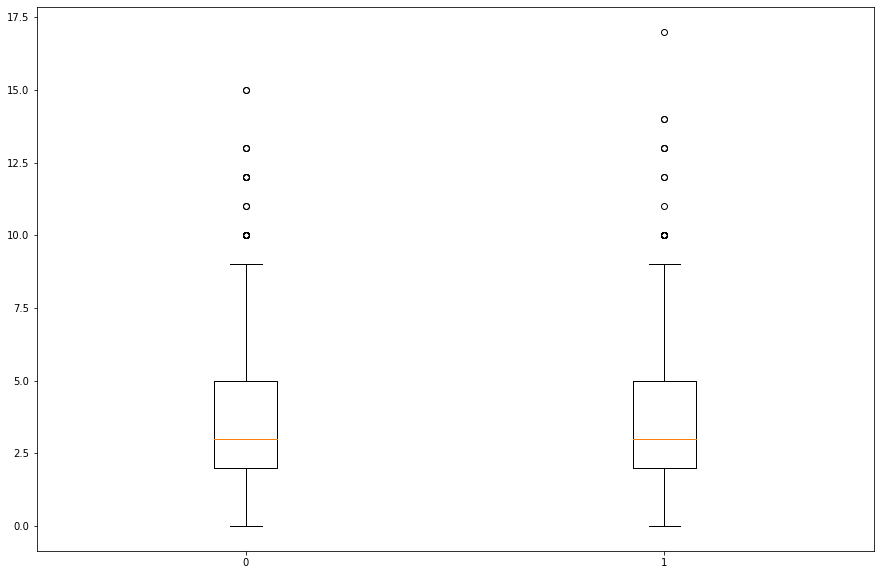

In [9]:
check(5,1000)

Generative function gives us a simple expression for the exact value of $\mathbb{P}(X_n=0 \mid X_0=1)$, see function below.

In [10]:
def proba_of_death(n):
    q=1/(m+1)
    p=m/(m+1)
    return ((p/q)**n-1)/((p/q)**(n+1)-1)

### Key function trajectories

Definition of the key function trajectories : given a potential, it simulates a system of $M$ interacting particles, and returns it as an array. It also returns the normalizing constant $C$, which is necessary to estimate further quantities, and cannot be estimated with the array X since some trajectories are eliminated in the selection-mutation process.

In [11]:
def trajectories(potential) : 
    
    X = np.zeros((M,n+1))     #will contain the M trajectories
    X[:,0] = M*[pop]   
    C = 1                     #initializing the normalizing constant
    
    for p in range(n):        #we want to extend trajectories to time p+1
        G = potential(X[:,:p+1])
        if p>0 :
            C = C * np.mean(G)
        I = np.random.choice(np.arange(M), size = M, replace = True, p = G/np.sum(G))
        X = X[I, :]                                         #selection
        X[:, p+1] = [markov(int(j)) for j in X[:, p]]       #mutation
  
    return (X, C)

Note : The function trajectories also allows us to see if a given potential is too selective or not. Too selective -> high inbredding

### Key function proba

The key function proba estimates the probability of the event in argument, using a system of interacting particles with the potential in argument.

In [12]:
def proba(event, potential) : 
    [X, C] = trajectories(potential)
    s=0
    for i in range(M) :
        if event(X[i, :]) :
            u=1
            for j in range(n-1) :
                u = u/potential(X[i, :j+2])
            s+=u
    return C*(1./M)*s

### 1. under-critic case

Under-critic case is defined by $m<1$. In this case, we have many theoretical results (see pdf). In particular, the population extinguished almost surely. Therefore, survival at generation $n$ becomes a rare event when $n$ grows.

### Event

Definition of the event we would like to estimate the probability of outcome

In [13]:
def survival(trajectory) : #return True iif the population is not extincted
    return (trajectory[-1]>0)

### Naive Monte Carlo estimator

A universal naive Monte_Carlo estimator. Useful to compare with other estimators, both in term of performance (variance and runtime) and correctness.

In [14]:
"event : event we want to estimate the probability"
"K : number of independent simulated trajectories"

def naive_MC(event, K) :
    X = np.zeros((K, n+1))           #X simply contains independent simulated trajectories
    X[:,0] = K*[pop]
    for j in range(n) :
        for i in range(K) :
            X[i,j+1]=markov(int(X[i,j]))
    B = [event(X[i,:]) for i in range(K)]
#    print("proba = {} (n={}, c={}, m={}, pop={})".format(np.mean(B),n,c,m,pop))
    return np.mean(B)

### Potentials

Definition of potentials used later to estimate probabilities. X always refers to an array, each line being a trajectory. Those functions always return an array containing the potential of each trajectory of X.

exp_inc_potential : $G_p(X_{0:p}) = e^{\lambda (X_p - X_{p-1})}$ (we use the notation $X_{0:p} := (X_0, ..., X_p)$)

In [15]:
lei=.5 #parameter of exp_inc_potential. To get optimized ! (see later)

In [16]:
def exp_inc_potential(X) :
    if len(np.shape(X)) == 2 :
        n = np.shape(X)[1]
        return np.exp(lei * (X[:, n-1] - X[:, n-2]))
    else :
        n = np.shape(X)[0]
        return np.exp(lei * (X[n-1] - X[n-2]))

exp_high_potential : $G_p(X_{0:p}) = e^{\lambda X_p}$

In [17]:
leh=.5

In [18]:
def exp_high_potential(X) :    #idem
    if len(np.shape(X)) == 2 :
        n = np.shape(X)[1]
        return np.exp(leh * X[:, n-1])
    else :
        n = np.shape(X)[0]
        return np.exp(leh * X[n-1])

lin_high_potential : $G_p(X_{0:p})=X_p$

In [19]:
def lin_high_potential(X) :
    if len(np.shape(X)) == 2 :
        n = np.shape(X)[1]
        return X[:, n-1]
    else :
        n = np.shape(X)[0]
        return X[n-1]

survival_potential : $G_p(X_{0:p})=1$ if $X_p > 0$, $0$ otherwise

In [20]:
def survival_potential(X) :
    if len(np.shape(X)) == 2 :
        n = np.shape(X)[1]
        Y = X[:, n-1]>0
        Z = [1. if y else 0. for y in Y]
        return np.array(Z)
    else :
        n = np.shape(X)[0]
        if X[n-1]>0 :
            return 1.
        else :
            return 0.

### Comparison between potentials

First, for potentials with a parameter 

Just below a code to guess the best value of the parameter of a potential

exact value is 0.00864520134824498
average value for each estimator : [8.35097082e-03 8.65797369e-03 9.13826484e-03 8.37807372e-03
 4.40191975e-22]
average runtime (in s) for each estimator : [0.009129652976989746, 0.009565062522888183, 0.009567580223083495, 0.031915102005004886, 0.04727694511413574]


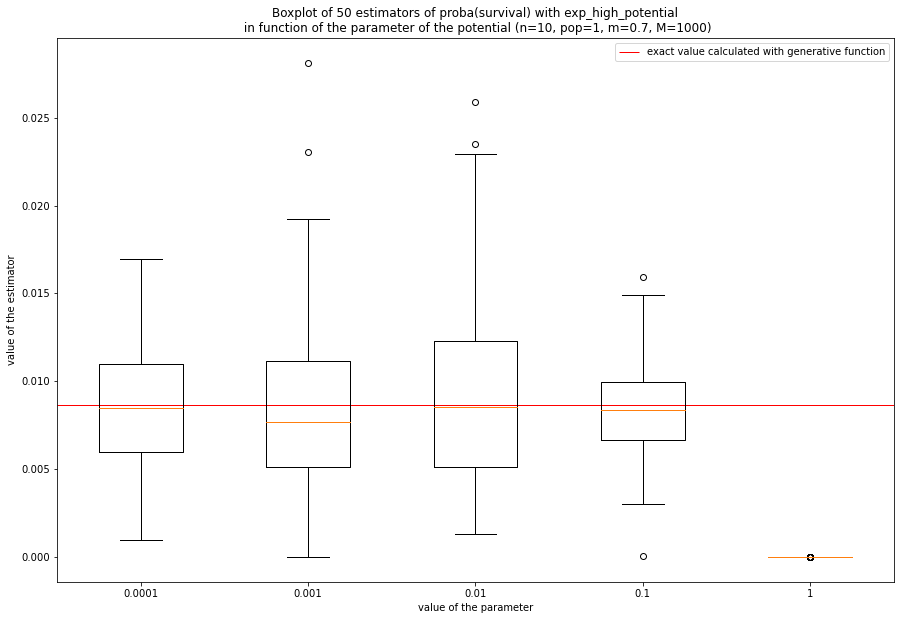

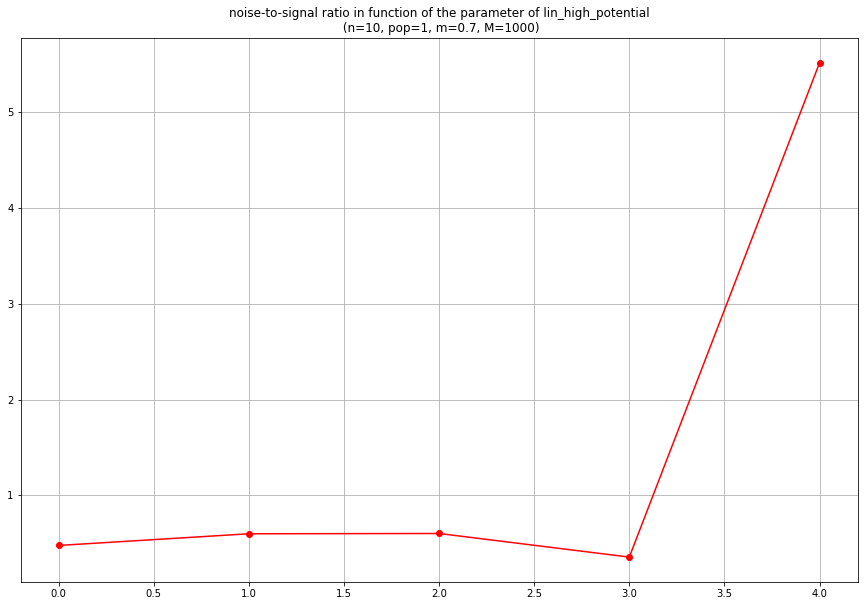

In [21]:
"parameters of the problem"
n=10
m=0.7
pop=1

"parameters of simulation"
M=1000

"parameters of the plot"

potential = exp_high_potential     # !!! change the parameter accordingly in the code !!!
event = survival
parameter = [0.0001, 0.001, 0.01, 0.1, 1]      #list of the values of the parameter we want to compare
K = 50                             #number of simulation for each value of the parameter

"core of the program"

l = len(parameter)
Stock = np.zeros((K, l))
Time=l*[0]
for i in range(l) :
    leh = parameter[i]             # !!!!!! depends on the potential !!!!!!
    t = time.time()
    for nn in range(K):
        Stock[nn, i] = proba(event, potential)
    u = time.time() - t
    Time[i] = u/K
            
plt.close(1)   
plt.figure(1)

######## to change in function of event and of potential  ############
plt.title("Boxplot of {} estimators of proba(survival) with exp_high_potential" 
            "\n in function of the parameter of the potential (n={}, pop={}, m={}, M={})".format(K,n,pop,m,M))
########

plt.boxplot(Stock[:, 0:l], positions=np.arange(l), labels = parameter)
plt.xlabel("value of the parameter")
plt.ylabel("value of the estimator")

if event == survival :
    th = 1 - proba_of_death(n)
    plt.hlines(th, -0.5, l-0.5, 'r', linewidth=1., label="exact value calculated with generative function")
    print("exact value is {}".format(th))
        
plt.legend(loc='best')

plt.close(2)
plt.figure(2)

mean_stock = np.mean(Stock, axis=0)

st_dev = np.std(Stock, axis=0)

plt.plot(st_dev/mean_stock,'r-o')
plt.title("noise-to-signal ratio in function of the parameter of lin_high_potential"
          "\n (n={}, pop={}, m={}, M={})".format(n,pop,m,M))
plt.grid()

print("average value for each estimator :", np.mean(Stock, axis=0))
print("average runtime (in s) for each estimator :", Time)

Just below a function to compare different potentials, possibly also with a naive Monte-Carlo estimator

In [22]:
"event is the event we want to estimate the probability"
"lst is a list of potentials"
"K is the number of times the probability of event will be estimated with each potential"
"b is a boolean : if True we also plot the naive MC estimator, if False we don't"

def comparison(K, event, lst, b) :
    l = len(lst)
    if b :
        Stock = np.zeros((K, l+1))       #Stock will contain all the realizations of all the estimators
        Time=(l+1)*[0]                   #Time will contain the average runtime for each estimator
        for est in range(l) :
            t = time.time()
            for nn in range(K):
                Stock[nn, est] = proba(event, lst[est])
            u = time.time() - t
            Time[est] = u/K
        t = time.time()
        for nn in range(K):
            Stock[nn, -1] = naive_MC(event, M)
        u = time.time() - t
        Time[-1] = u/K
        
        plt.close(1)   
        plt.figure(1)

########## to modify in function of event ##############
        plt.title("Boxplot of {} estimators of proba(survival) with different potentials"
              " \n (n={}, pop={}, m={}, M={})".format(K,n,pop,m,M))
##########

########## to modify in function of the potentials ##############
        plt.boxplot(Stock[:, 0:l+1], positions=np.arange(l+1), 
                    labels=["survival","exp_high","MC"])
##########

        plt.ylabel("value of the estimators")

        if event == survival :
            th = 1 - proba_of_death(n)
            plt.hlines(th, -0.5, l+0.5, 'r', linewidth=1., 
                       label="exact value calculated with generative function")
            print("exact value = {}".format(th))
        
        plt.legend(loc='best')   
        
        plt.close(2)
        plt.figure(2)

        mean_stock = np.mean(Stock, axis=0)

        st_dev = np.std(Stock, axis=0)

        plt.plot(st_dev/mean_stock,'r-o')
        plt.title("noise-to-signal ratio for each potential")
        plt.grid()

        print("average value for each estimator :", np.mean(Stock, axis=0))
        print("average runtime (in s) for each estimator :", Time)
        
    else :
        Stock = np.zeros((K, l))
        Time=l*[0]
        for est in range(l) :
            t = time.time()
            for nn in range(K):
                Stock[nn, est] = proba(event, lst[est])
            u = time.time() - t
            Time[est] = u/K

        plt.close(1)   
        plt.figure(1)

########## to modify in function of event ##############
        plt.title("Boxplot of {} estimators of proba(survival) with different potentials"
              " \n (n={}, pop={}, m={}, M={})".format(K,n,pop,m,M))
##########

########## to modify in function of the potentials ##############
        plt.boxplot(Stock[:, 0:l], positions=np.arange(l),
                   labels=["survival","exp_high"])
##########

        plt.ylabel("value of the estimators")

        if event == survival :
            th = 1 - proba_of_death(n)
            plt.hlines(th, -0.5, l-0.5, 'r', linewidth=1., 
                       label="exact value calculated with generative function")
            print("exact value = {}".format(th))
        
        plt.legend(loc='best')   
        
        plt.close(2)
        plt.figure(2)

        mean_stock = np.mean(Stock, axis=0)

        st_dev = np.std(Stock, axis=0)

        plt.plot(st_dev/mean_stock,'r-o')
        plt.title("noise-to-signal ratio for each potential")
        plt.grid()

        print("average value for each estimator :", np.mean(Stock, axis=0))
        print("average runtime (in s) for each estimator :", Time)

exact value = 0.0002395105765347072
average value for each estimator : [0.00024199 0.        ]
average runtime (in s) for each estimator : [0.06173388957977295, 0.014113903045654297]


/Users/adrien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide


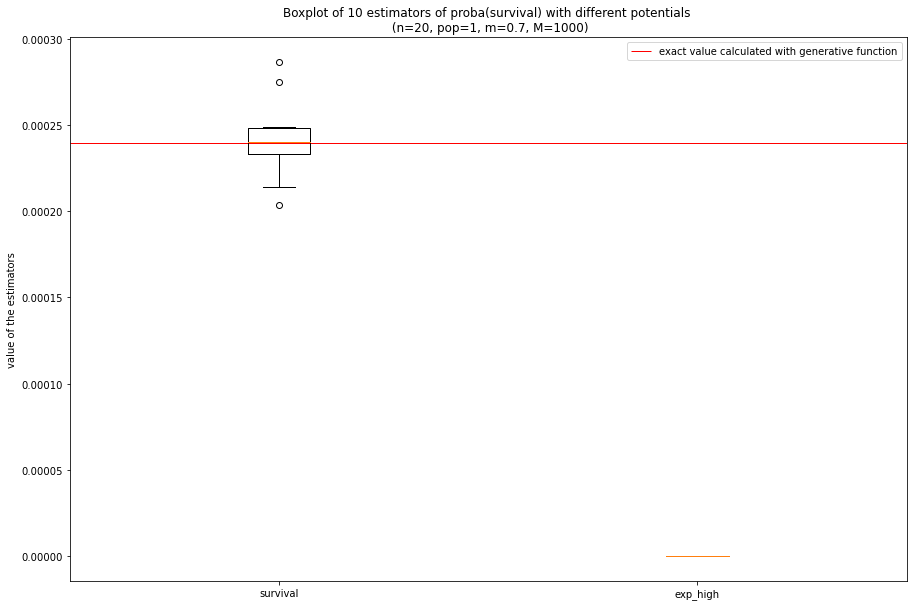

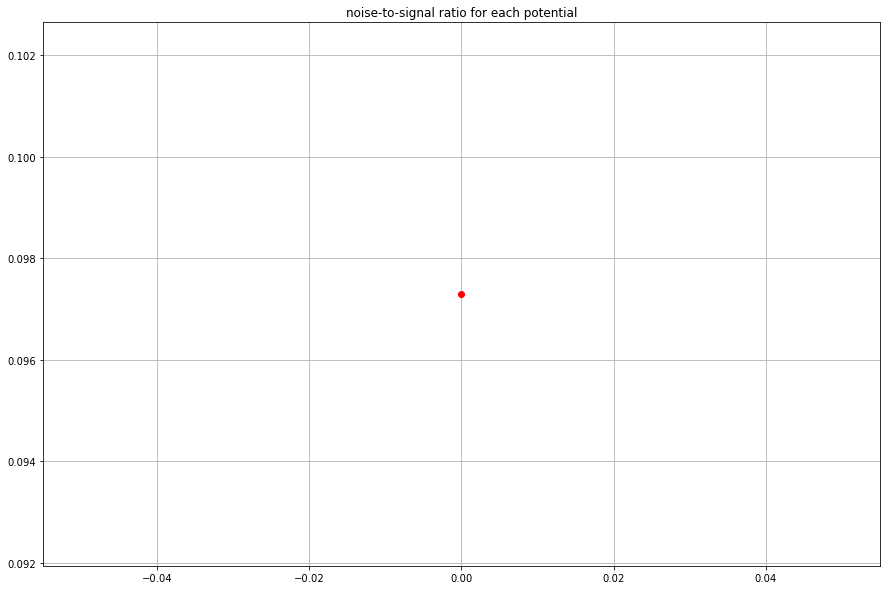

In [23]:
n=20
m=0.7
M=1000
leh=0.01      # nearly optimal value for exp_high_potential
comparison(10, survival, [survival_potential, exp_high_potential], False)

Just below a code to see the impact of simulation parameter $M$ on the quality of an estimator

exact value = 0.00864520134824498
average value for each value of M : [0.00828438 0.00868476 0.0083943 ]
average runtime (in s) for each value of M : [0.00535888671875, 0.016905498504638673, 0.031340813636779784]


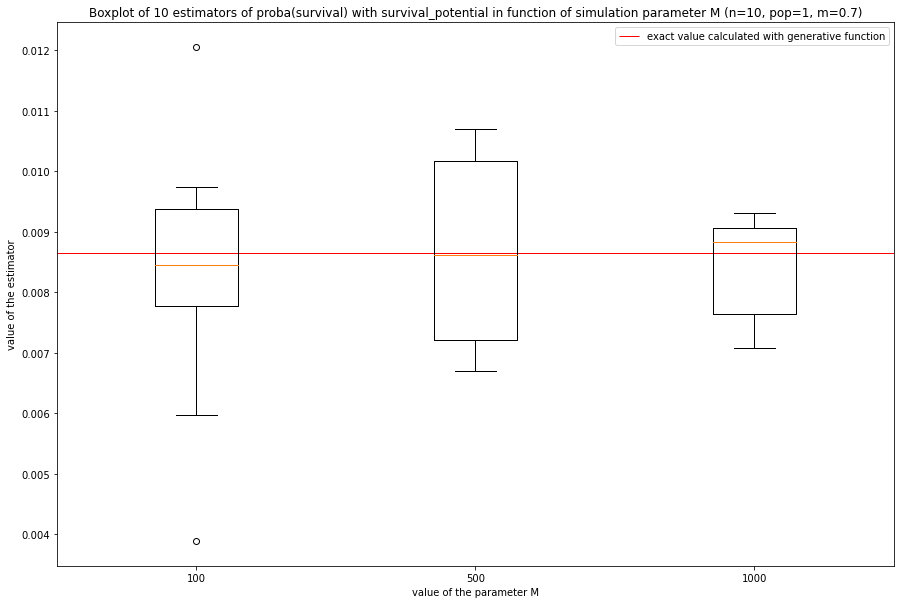

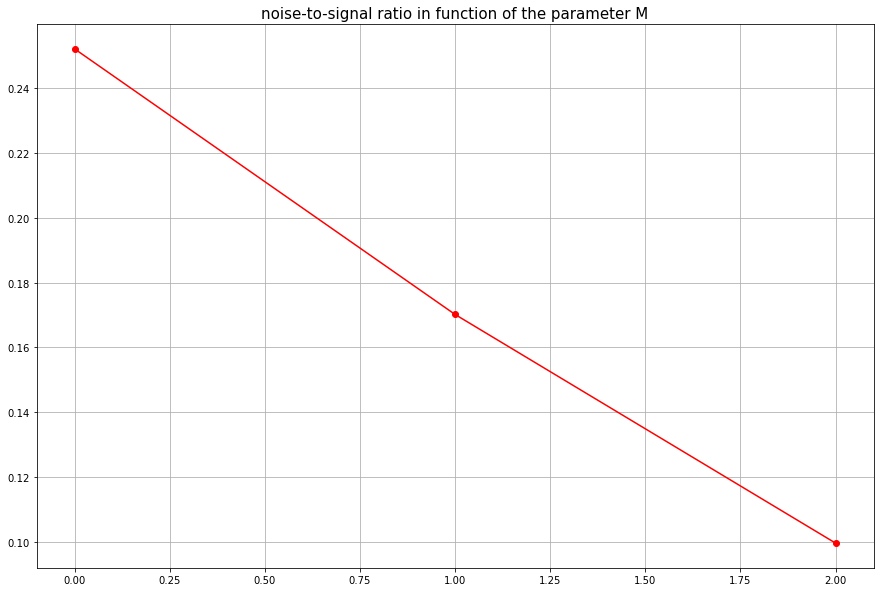

In [24]:
"parameters of the problem"
n = 10
pop = 1
m = 0.7

"values : set of values of parameter M to test"
"K : number of simulations for each value of M"

values =[100, 500, 1000]
K=10

"just change some names in what follows, where it is indicated"

l = len(values)
Stock = np.zeros((K,l))

Time=l*[0]
for j in range(l) :
    M = values[j]             #modification of the global parameter M
    t = time.time()
    for i in range(K) :
        Stock[i,j] = proba(survival, survival_potential)   #depends on event, potential
    u = time.time() - t
    Time[j] = u/K

######## to change in function of event and potential ############
plt.title("Boxplot of {} estimators of proba(survival) with survival_potential "
          "in function of simulation parameter M (n={}, pop={}, m={})".format(K,n,pop,m))
########

plt.boxplot(Stock[:, 0:l], positions=np.arange(l),
                labels = [str(x) for x in values])
plt.xlabel("value of the parameter M")
plt.ylabel("value of the estimator")

###### if event == suvival
th = 1 - proba_of_death(n)
plt.hlines(th, -0.5, l-0.5, 'r', linewidth=1., label="exact value calculated with generative function")
plt.legend(loc='best')
print("exact value = {}".format(th))
#######

plt.close(2)
plt.figure(2)

mean_stock = np.mean(Stock, axis=0)

st_dev = np.std(Stock, axis=0)

plt.plot(st_dev/mean_stock,'r-o')
plt.title("noise-to-signal ratio in function of the parameter M", fontsize=15)
plt.grid()

print("average value for each value of M :", np.mean(Stock, axis=0))
print("average runtime (in s) for each value of M :", Time)

Note: Shows the effect of increasing $M$ (less noise but more runtime). Warning ! If $M$ is too small it can crash (case where all the trajectories die at a same generation)

Just below, a code to check whether an estimator is biaised or not, using law of large numbers

Text(0.5, 1.0, 'consistency of the estimator with survival_potential (n=10, pop=1, m=0.7, M=100)')

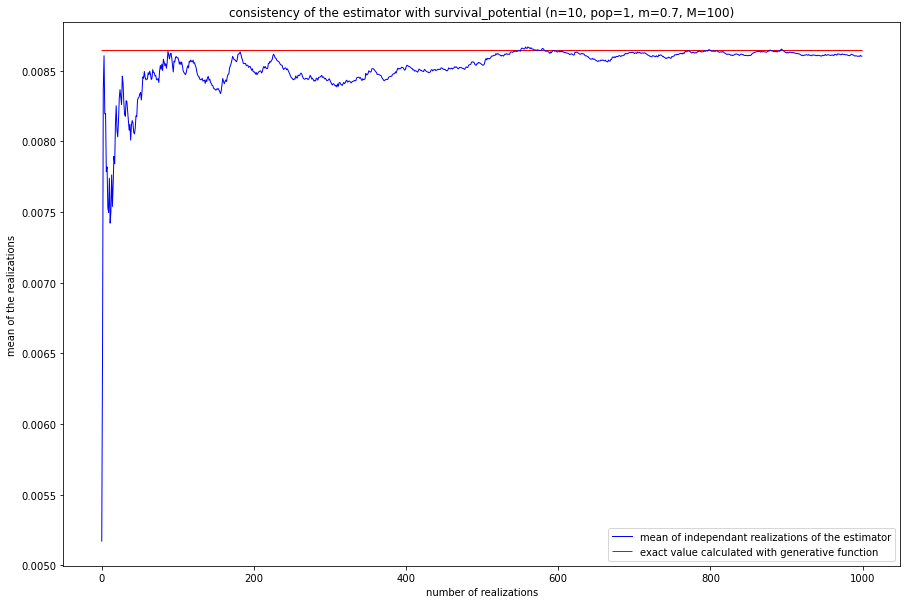

In [25]:
"parameters of the problem"
n = 10
pop = 1
m = 0.7

"simulation parameters"
M = 100

"plot parameters"
z = 1000     #number of independant realizations of the estimator 

"core of the program"
Stock = []
for _ in range(z) :
    Stock.append(proba(survival, survival_potential))  #depends on event, potential

est = np.cumsum(Stock)/np.arange(1, z+1)

plt.plot(est,'b', linewidth=1., label="mean of independant realizations of the estimator")

###### if event == suvival
th = 1 - proba_of_death(n)
plt.hlines(th, -0.5, z-0.5, 'r', linewidth=1., label="exact value calculated with generative function")
#######

plt.legend(loc='best')
plt.xlabel("number of realizations")
plt.ylabel("mean of the realizations")
plt.title("consistency of the estimator with survival_potential (n={}, pop={}, m={}, M={})".format(n,pop,m,M))

Note : we see that the estimator with survival_potential is consistent (good news)

#### Conclusion : we will use survival_potential in what follows

### Generation of scenarii leading to a survival at the nth generation

First, a naive manner : we simulate normal trajectories INDEPENDENTLY, and select randomly trajectories among those which survive

In [26]:
def scenarii_naive(K) : #naive generation 
    
    a = 10000            #set the inverse of survival probability plus epsilon
    l = K*a
    X = np.zeros((l, n+1))
    X[:,0] = l*[pop]
    for j in range(n) :
        for i in range(l) :
            X[i,j+1]=markov(int(X[i,j]))
    Y=X[X[:, -1]>0]       
    
    for i in range(K) :
        plt.plot(np.arange(n+1),Y[i, :], linewidth=1.5)
    plt.title("{} survival scenarii at generation {} (naive simulation) m={}, pop={}".format(K,n,m,pop))

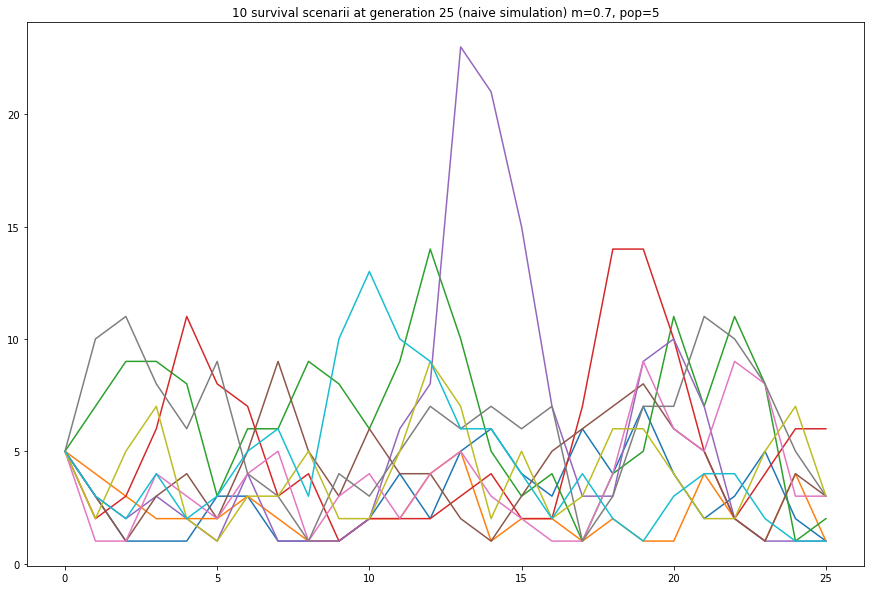

In [27]:
m=0.7
n=25
pop=5
scenarii_naive(10)

Second, we simulate trajectories under survival_potential, and then select uniformly trajectories among those which don't die at the last generation. See pdf to know why it is mathematically correct.

In [28]:
def scenarii(K) : #K number of scenarii
    X=trajectories(survival_potential)[0]
    Y=X[X[:, -1]>0]       #we eliminate the trajectories that die at the last generation
    
    for i in range(K) :
        plt.plot(np.arange(n+1),Y[i, :], linewidth=1.5)
    plt.title("{} survival scenarii at generation {} (simulation with survival_potential) "
                    "m={}, pop={}, M={}".format(K,n,m,pop,M))

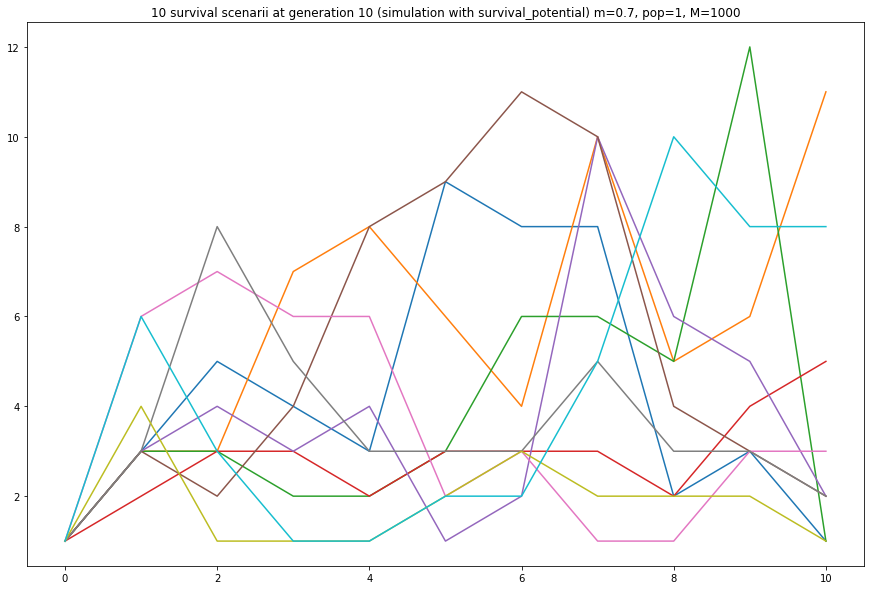

In [29]:
m=0.7
n=10
pop=1
M=1000
scenarii(10)

Note : select a small value of $M$ to see what imbreeding looks like

### Conditional distribution

When $n$ tends to $\infty$, the distribution of $X_n$ conditionnal to $X_n > 0$ tends in law to cond_distrib defined just below. $pop$ has no influence on this.

In [30]:
def cond_distrib(i) :
    return (1-m)*m**(i-1)

Very naive way to estimate the conditionnal distribution 

In [31]:
"v_max : maximum value we want to see"
"K : number of simulated trajectories"

def conditionnal_distrib_naive(K, v_max) : #naive generation 
    
    a = 1000            #inverse of survival probability plus espilon
    l = K*a
    X = np.zeros((l, n+1))
    X[:,0] = l*[pop]
    for j in range(n) :
        for i in range(l) :
            X[i,j+1]=markov(int(X[i,j]))
    Z=X[X[:, -1]>0] 
    Y = K*[0]
    for i in range(K) :
        Y[i] = Z[i,-1]
    
    counts = np.bincount(Y, minlength = v_max + 1)[1:]
    counts = counts / K
    valeurs=np.arange(1, v_max + 1) 
    
    plt.stem(valeurs, counts[:v_max], linefmt="r", markerfmt="ro", basefmt="None", 
             label="distribution conditionnal to survival")
    plt.legend(loc='best')
    plt.title("distribution conditional to survival at generation {}".format(n))
    plt.show()
    
    s = np.sum(counts[:v_max])
    print("sum of printed probabilities = {}".format(s))

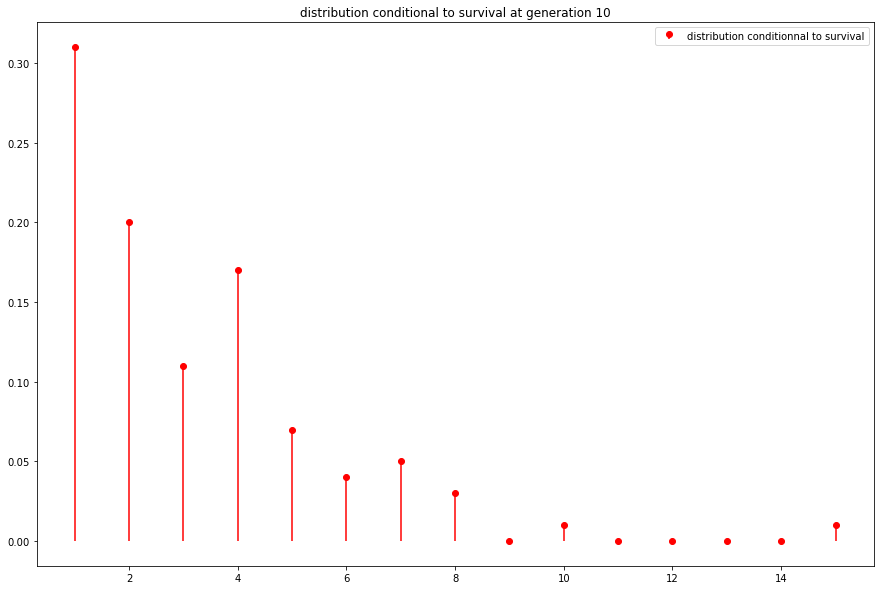

sum of printed probabilities = 1.0


In [32]:
n=10
conditionnal_distrib_naive(100, 15)

First approach with trajectories

Warning : Take $M$ big enough in function of $n$ and $K$ to avoid imbreeding

In [33]:
"v_max : maximum value we want to see"
"K : number of selected trajectories"

def conditional_distrib(v_max, K) : 

    X = trajectories(survival_potential)[0]
    Z = X[X[:, -1]>0]  
    Y = K*[0]
    for i in range(K) :
        Y[i] = Z[i,-1]
    
    counts = np.bincount(Y, minlength = v_max + 1)[1:]
    counts = counts / K
    valeurs=np.arange(1, v_max + 1) 
    
    plt.stem(valeurs, counts[:v_max], linefmt="r", markerfmt="ro", basefmt="None", 
             label="estimated conditionnal law")
    plt.legend(loc='best')
    plt.title("estimated conditionnal distribution at generation {} (m={}, pop={}, M={})".format(n,m,pop,M))
    plt.show()
    
    s = np.sum(counts[:v_max])
    print("sum of printed probabilities = {}".format(s))

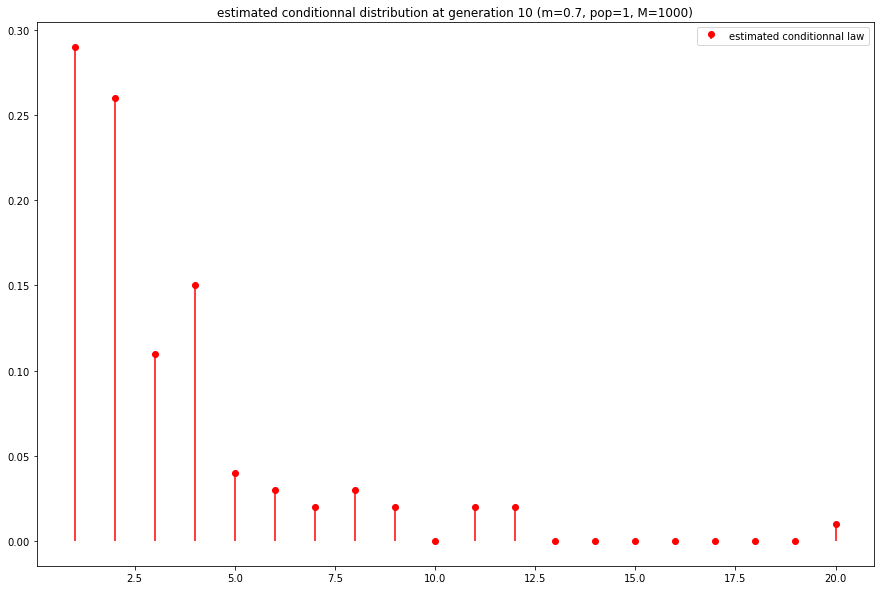

sum of printed probabilities = 1.0


In [34]:
M=1000
conditional_distrib(20, 100)

Second approach with direct estimation

It appears that this second method is better, so we use it to make precise estimations with confidence intervals

In [35]:
"v_max : maximum value we want to see"
"K : number of times we estimate each probability"
"gamma : confidence level"

def conditional_distribution2(v_max, K, gamma) :
    
    Stock = np.zeros((K, v_max))
    for j in range(K) :
        X = trajectories(survival_potential)[0]
        Z = X[X[:, -1]>0]
        L = np.shape(Z)[0]
        Y = L*[0]
        for i in range(L) :
            Y[i] = int(Z[i, -1])
    
        counts = np.bincount(Y, minlength = v_max + 1)[1:]
        counts = counts / L
        counts = counts[:v_max]
        Stock[j, :] = counts
        
    values = []
    std = []
    
    for j in range(v_max) :
        A = confidence(Stock[:,j], gamma)
        values.append(A[0])
        std.append(A[1][1] - A[0])
    
    plt.bar(np.arange(1, v_max+1), values, width = 0.2, color = 'r', tick_label =np.arange(1, v_max+1),
            yerr=std, label="estimated distribution conditional to survival "
            "({} simulations, confidence level = {})".format(K, gamma))
    plt.stem(np.arange(1, v_max + 1)+0.2, [cond_distrib(x) for x in np.arange(1, v_max + 1)], 
             linefmt="b", label="asymptotic conditionnnal distribution")
    plt.legend(loc='best')
    plt.title("estimated distribution conditional to survival at generation {} " 
              "(m={}, pop={}, M={})".format(n,m,pop,M))
    
    s = np.sum(values)
    print("sum of printed probabilities ={}".format(s))

sum of printed probabilities =0.99862922630486


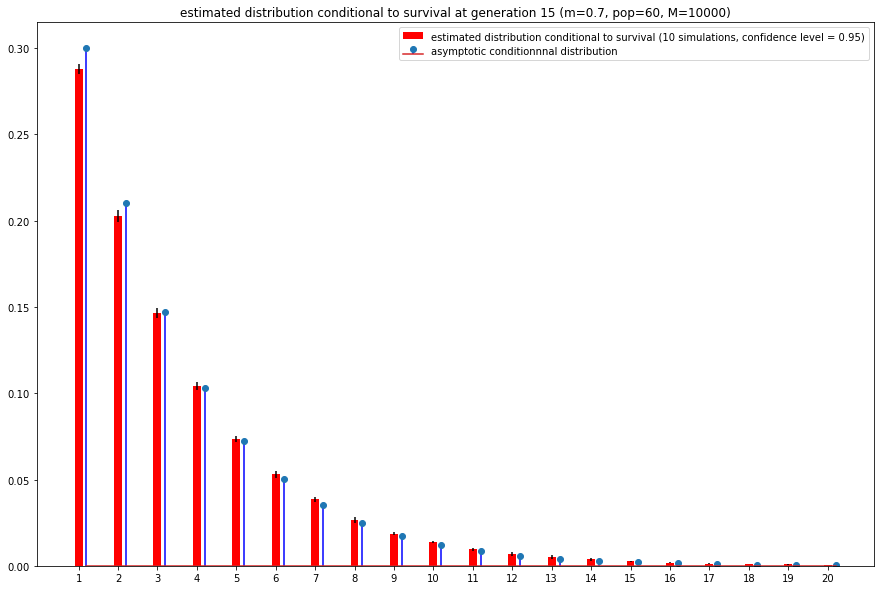

In [36]:
n=15
m=0.7
pop=60
M=10000
conditional_distribution2(20, 10, 0.95)

### Study of probability of survival

We can prove that the following expressions are always greater (resp. smaller) than the actual probability of survival

In [37]:
def survival_sup(n) :
    return pop*m**n

In [38]:
def survival_inf(n) :
    return (pop*(1-m)*m**n)/(1+m-2*m**(n+1))

Now a code to plot probability of survival in function of $n$

Text(0.5, 1.0, 'Probability of survival in function of generation (m=0.7, pop=1, M=100)')

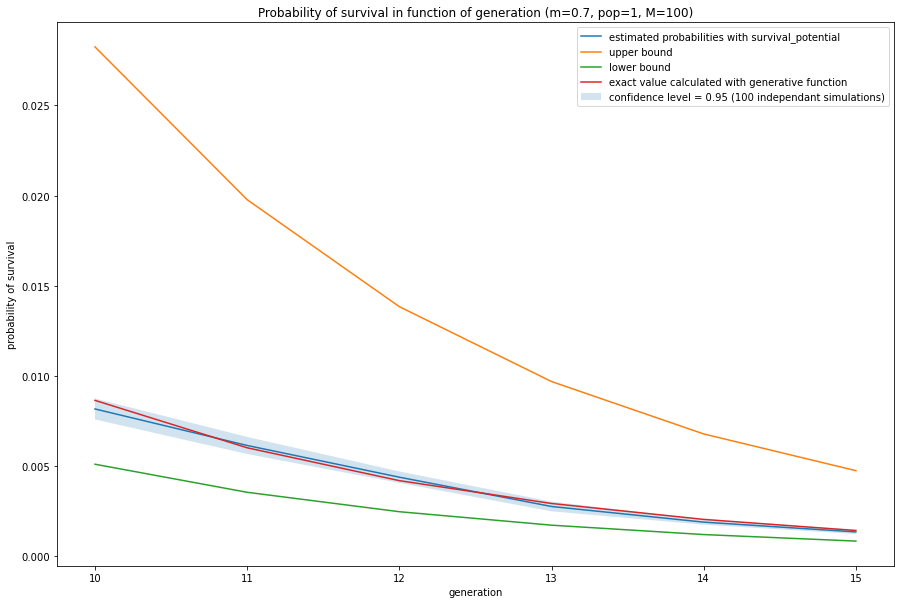

In [39]:
"parameters of the problem"
m=0.7
pop=1
# not n because here the generation varies, see "parameters of the plot"

"parameters of simulation"
M=100

"parameters of the plot"

z=15               #last generation
a=10               #first generation
K=100              #number of simulations for each estimated probability
gamma = 0.95       #confidence level

"core of the program"

list_prob=[]      #list of estimated probabilities
list_sup=[]
list_inf=[]
X=[]
for i in range(a,z+1):
    n=i                   #modification of the global parameter n
    X=[]
    for _ in range(K) :
        X.append(proba(survival, survival_potential))
    A = confidence(X, gamma)
    list_prob.append(A[0])
    list_sup.append(A[1][1])
    list_inf.append(A[1][0])
    

fig, ax = plt.subplots()
ax.plot(range(a,z+1), list_prob, '-', label ="estimated probabilities with survival_potential")
ax.plot(range(a,z+1), [survival_sup(x) for x in range(a,z+1)], '-', label ="upper bound")
ax.plot(range(a,z+1), [survival_inf(x) for x in range(a,z+1)], '-', label ="lower bound")
ax.fill_between(range(a,z+1), list_inf, list_sup, alpha=0.2, 
                label="confidence level = {} ({} independant simulations)".format(gamma, K))

plt.plot(range(a,z+1),[1.0-proba_of_death(i)**pop for i in range(a,z+1)], 
         label="exact value calculated with generative function")
plt.xlabel("generation")
plt.ylabel("probability of survival")
plt.legend(loc='best')
plt.title("Probability of survival in function of generation (m={}, pop={}, M={})".format(m, pop,M))

### 2. over-critic case

Defined by $m>1$

Normalized trajectories = $(\frac{X_n}{m^n})_n$

In [40]:
def normalized_trajectories_generator(K, n) : #naive generation 

    X = np.zeros((K, n+1))
    X[:,0] = K*[pop]
    for j in range(n) :
        for i in range(K) :
            X[i,j+1]=markov(int(X[i,j]))
    X = X / np.array([[m**j for j in range(n+1)] for _ in range(K)])
    
    for i in range(K) :
        plt.plot(np.arange(n+1),X[i, :], linewidth=1.5)
    plt.title("{} normalized trajectories to generation {} (naive simulation) m={}, pop={}".format(K,n,m,pop))
    plt.xlabel("generation")
    plt.savefig("130.jpg", dpi=1000)
    proba = len(X[X[:,-1]==0])/K
    print("proportion of trajectories that die = {}".format(proba))
    print("proba for a trajectory to die = {}".format(1./m))

proportion of trajectories that die = 0.36
proba for a trajectory to die = 0.3333333333333333


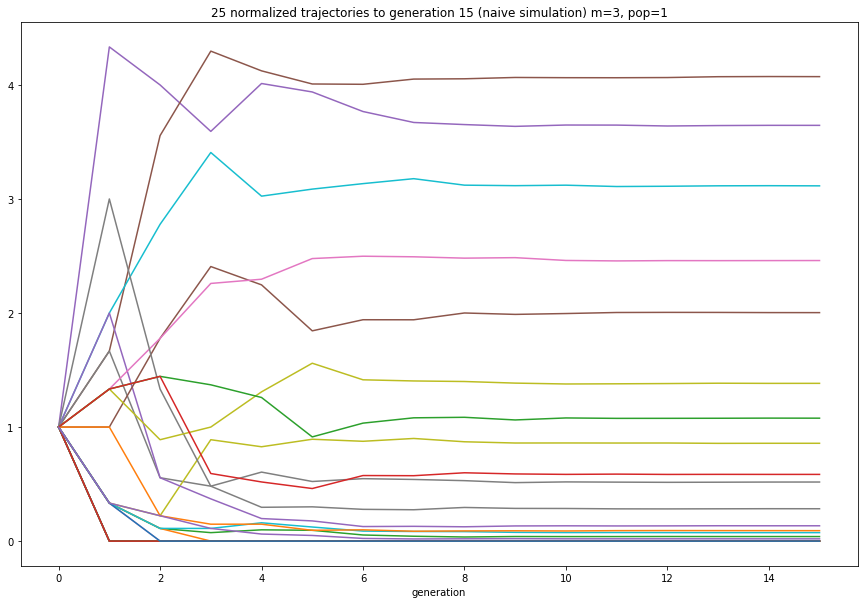

In [41]:
pop=1
m=3
normalized_trajectories_generator(25,15)

Note : it illustrates the fact that the normalized trajectories converge a.s.

### Event

In [42]:
c = 1.5      #global variable
def undergrowth(trajectory) : 
    p = len(trajectory)
    return (0<trajectory[p-1]<=trajectory[0]*c**(p-1))

### Potentials

In [43]:
lel = 1

In [44]:
def exp(X) :
    rep = []
    p = len(X)
    for i in range(p) :
        if X[i] > 0 :
            rep.append(np.exp(-lel * X[i]))
        else :
            rep.append(0)
    return np.array(rep) 

In [45]:
def exp2(x) :
    if x > 0 :
        return np.exp(-lel * x)
    else :
        return 0

In [46]:
def exp_low_potential(X) :    # X np array
    if len(np.shape(X)) == 2 :
        n = np.shape(X)[1]
        return exp(X[:, n-1])
    else :
        n = np.shape(X)[0]
        return exp2(X[n-1])

In [47]:
def inv(X) :
    rep = []
    p = len(X)
    for i in range(p) :
        if X[i] > 0 :
            rep.append(1./X[i])
        else :
            rep.append(0)
    return np.array(rep)

In [48]:
def inv2(x) :
    if x > 0 :
        return 1./x
    else :
        return 0

In [49]:
def inverse_potential(X) :
    if len(np.shape(X)) == 2 :
        n = np.shape(X)[1]
        return inv(X[:, n-1])
    else :
        n = np.shape(X)[0]
        return  inv2(X[n-1])

In [50]:
def l2(x) :
    if x>7 :
        return 1./np.log(x)
    elif 0<x<8 :
        return 0.5
    else :
        return 0

In [51]:
def le(X) :
    rep = []
    p = len(X)
    for i in range(p) :
        rep.append(l2(X[i]))
    return np.array(rep)

In [52]:
def log_potential(X) :
    if len(np.shape(X)) == 2 :
        n = np.shape(X)[1]
        return le(X[:, n-1])
    else :
        n = np.shape(X)[0]
        return  l2(X[n-1])

In [53]:
b =0.1
def lb2(x) :
    if x>7 :
        return max(1./np.log(x), b)
    elif 0<x<8 :
        return 0.5
    else :
        return 0

In [54]:
def lb(X) :
    rep = []
    p = len(X)
    for i in range(p) :
        rep.append(lb2(X[i]))
    return np.array(rep)

In [55]:
def log_b_potential(X) :
    if len(np.shape(X)) == 2 :
        n = np.shape(X)[1]
        return lb(X[:, n-1])
    else :
        n = np.shape(X)[0]
        return  lb2(X[n-1])

In [56]:
def ll2(x) :
    if x>15 :
        return 1./np.log(np.log(x))
    elif 0<x<=15 :
        return 1
    else :
        return 0

In [57]:
def ll(X) :
    rep = []
    p = len(X)
    for i in range(p) :
        rep.append(ll2(X[i]))
    return np.array(rep)

In [58]:
def log_log_potential(X) :
    if len(np.shape(X)) == 2 :
        n = np.shape(X)[1]
        return ll(X[:, n-1])
    else :
        n = np.shape(X)[0]
        return  ll2(X[n-1])

Just below a code to guess the best value of the parameter of a potential

No handles with labels found to put in legend.


average value for each estimator : [3.20748906e-08 1.70470998e-07 7.52055246e-07 4.51274213e-07
 4.11145704e-06 0.00000000e+00]
average runtime (in s) for each estimator : [0.028240680694580078, 0.024839210510253906, 0.025592780113220213, 0.03226711750030518, 0.022447705268859863]


/Users/adrien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


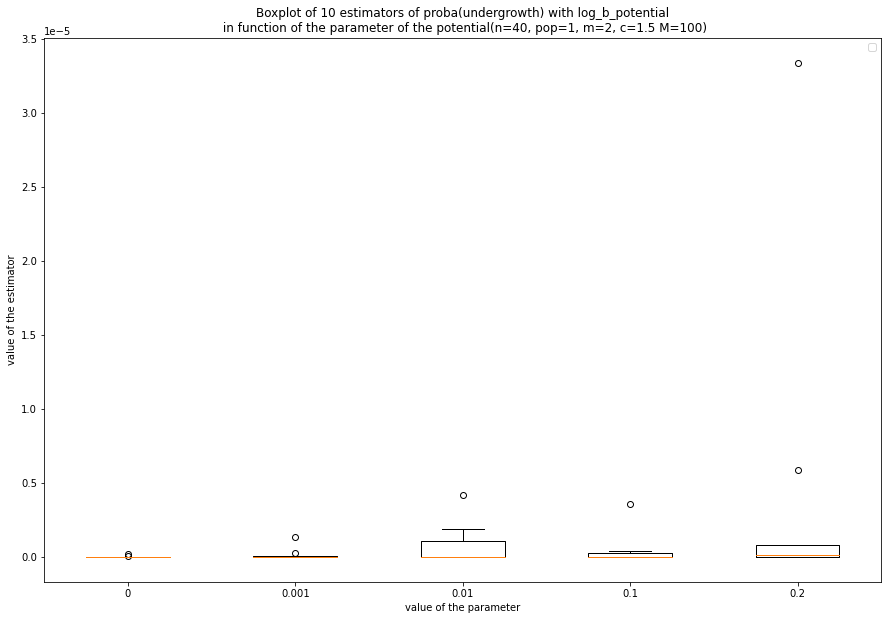

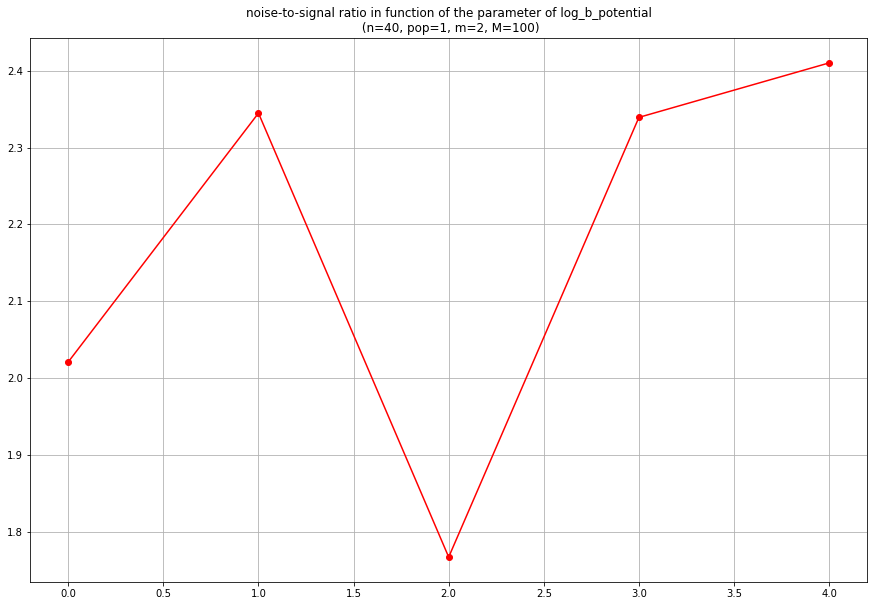

In [59]:
"parameters of the problem"
n=40
m=2
pop=1
c=1.5

"parameters of simulation"
M=100

"parameters of the plot"

potential = log_b_potential     # !!! change the parameter accordingly in the code !!!
event = undergrowth
parameter = [0,0.001,0.01,0.1,0.2]      #list of the values of the parameter we want to compare
K = 10                            #number of simulation for each value of the parameter

"core of the program"

l = len(parameter)
Stock = np.zeros((K, l+1))
Time=l*[0]
for i in range(l) :
    b = parameter[i]             # !!!!!! depends on the potential !!!!!!
    t = time.time()
    for nn in range(K):
        Stock[nn, i] = proba(event, potential)
    u = time.time() - t
    Time[i] = u/K

            
plt.close(1)   
plt.figure(1)

######## to change in function of event and of potential  ############
plt.title("Boxplot of {} estimators of proba(undergrowth) with log_b_potential" 
            "\n in function of the parameter of the potential"
          "(n={}, pop={}, m={}, c={} M={})".format(K,n,pop,m,c,M))
########

plt.boxplot(Stock[:, 0:l], positions=np.arange(l), labels = parameter)
plt.xlabel("value of the parameter")
plt.ylabel("value of the estimator")

if event == survival :
    th = 1 - proba_of_death(n)
    plt.hlines(th, -0.5, l-0.5, 'r', linewidth=1., label="exact value calculated with generative function")
    print("exact value is {}".format(th))
        
plt.legend(loc='best')

plt.close(2)
plt.figure(2)

mean_stock = np.mean(Stock, axis=0)

st_dev = np.std(Stock, axis=0)

plt.plot(st_dev/mean_stock,'r-o')
plt.title("noise-to-signal ratio in function of the parameter of log_b_potential"
          "\n (n={}, pop={}, m={}, M={})".format(n,pop,m,M))
plt.grid()

print("average value for each estimator :", np.mean(Stock, axis=0))
print("average runtime (in s) for each estimator :", Time)

We can use the function comparison defined above to compare potentials ! Finaly, log_potential and log_log_potentials are the best and we use them.

Just below a code to estimate proba(undergrowth) in function of the generation

Text(0.5, 1.0, 'probability of undergrowth in function of generation (m=2, c=1.5, pop=1, M=1000)')

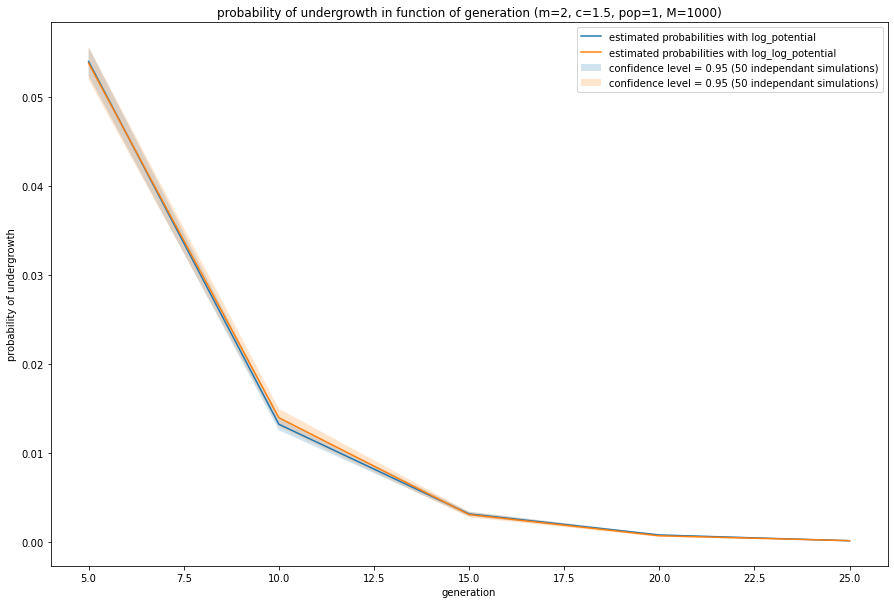

In [60]:
"parameters of the problem"
m=2
pop=1
c = 1.5
# not n because here the generation varies, see "parameters of the plot"

"parameters of simulation"
M=1000

"parameters of the plot"

gen = [5, 10, 15, 20, 25]  #set of generations we are looking at
K=50                       #number of simulations for each estimated probability
gamma = 0.95            #confidence level

"core of the program"

list_prob=[]       #list of estimated probabilities with log_potential
list_sup=[]
list_inf=[]
list_prob2=[]      #list of estimated probabilities with log_log_potential
list_sup2=[]
list_inf2=[]
X=[]
for i in gen :
    n=i                   #modification of the global parameter n
    X=[]
    for _ in range(K) :
        X.append(proba(undergrowth, log_potential))
    A = confidence(X, gamma)
    list_prob.append(A[0])
    list_sup.append(A[1][1])
    list_inf.append(A[1][0])
for i in gen :
    n=i                   #modification of the global parameter n
    X=[]
    for _ in range(K) :
        X.append(proba(undergrowth, log_log_potential))
    A = confidence(X, gamma)
    list_prob2.append(A[0])
    list_sup2.append(A[1][1])
    list_inf2.append(A[1][0])
    

fig, ax = plt.subplots()
ax.plot(gen, list_prob, '-', label ="estimated probabilities with log_potential")
ax.fill_between(gen, list_inf, list_sup, alpha=0.2, 
                label="confidence level = {} ({} independant simulations)".format(gamma, K))
ax.plot(gen, list_prob2, '-', label ="estimated probabilities with log_log_potential")
ax.fill_between(gen, list_inf2, list_sup2, alpha=0.2, 
                label="confidence level = {} ({} independant simulations)".format(gamma, K))

plt.xlabel("generation")
plt.ylabel("probability of undergrowth")
plt.legend(loc='best')
plt.title("probability of undergrowth in function of generation (m={}, c={}, pop={}, M={})".format(m, c, pop,M))

In [61]:
def scenarii_ug_naive(K) :
    X = np.zeros((M, n+1))
    X[:,0] = M*[pop]
    for j in range(n) :
        for i in range(M) :
            X[i,j+1]=markov(int(X[i,j]))
    B = [undergrowth(X[i, :]) for i in range(M)]
    X=X[B]
    for i in range(K) :
        plt.plot(np.arange(n+1), X[i, :], linewidth=1.5)
    plt.plot(np.arange(0,n+0.1,0.1), [c**x for x in np.arange(0,n+0.1,0.1)], label='limite of undergrowth')
    plt.title("{} undergrowth scenarii at generation {} (naive simulation) "
                    "m={}, pop={}, c={}, M={}".format(K,n,m,pop,c,M))
    plt.xlabel("generation")
    plt.legend(loc='upper left')

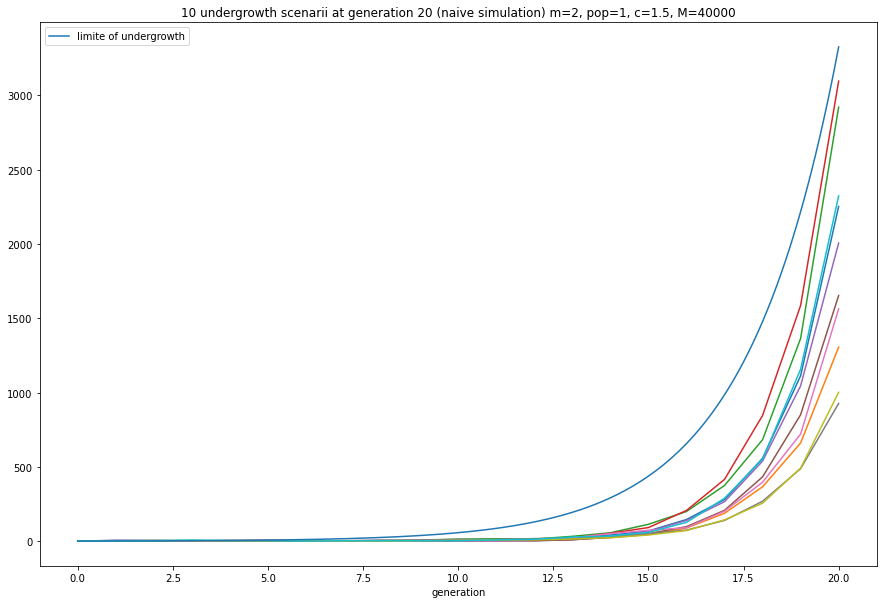

In [62]:
M=40000
n=20
scenarii_ug_naive(10)

In [63]:
def scenarii_ug(K, potential) : #K number of scenarii
    X=trajectories(potential)[0]
    B = [undergrowth(X[i, :]) for i in range(M)]
    u = np.sum(B)
    X=X[B]
    
    W = u*[0]
    for i in range(u) :
        r = 1
        for j in range(n-1) :
            r = r*potential(X[i, :j+2])
        W[i] = 1/r
        
    I = np.random.choice(np.arange(u), size = K, replace = False, p = W/np.sum(W))
    
    for i in I :
        plt.plot(np.arange(n+1), X[i, :], linewidth=1.5)
    plt.plot(np.arange(0,n,0.1), [c**x for x in np.arange(0,n,0.1)], label='lim')
    plt.title("{} undergrowth scenarii at generation {} (simulation with log_potential) "
                    "m={}, pop={}, c={}, M={}".format(K,n,m,pop,c,M))
    plt.legend(loc='best')

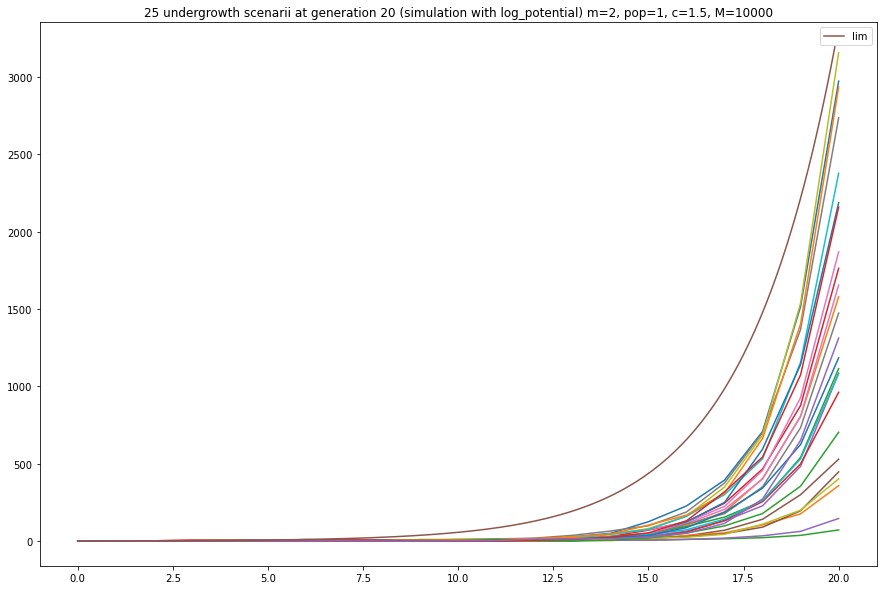

In [64]:
n=20
M=10000
m=2
c=1.5
pop=1
scenarii_ug(25, log_potential)

### II. More complex reproduction law

Now the reproduction law is more complex : at each generation, we choose randomly and indepently between two environnment. With probability p_fav we get a reproduction law 

In [65]:
"problem parameters"
n = 10
pop = 1

"simulation parameters"
M = 100

"parameters of the second part of the project"
p_fav = .8         #probability, at one given generation, to get on average m_1 children per individual
m_1 = 2       
m_0 = .5

Definition of the slightly more complicated Markov chain for the second part. Also returns 1 for favorable environement, 0 for defavorable environnement (will be useful later)

In [66]:
def markov2(k) :
    u = np.random.rand()
    if u<p_fav :
        if k == 0 :
            return (0,1)
        else :
            return (np.random.negative_binomial(k, 1./(m_1+1)), 1)
    else :
        if k ==0 :
            return (0,0)
        else :
            return (np.random.negative_binomial(k, 1./(m_0+1)), 0)

A fonction to determine whether we are in under-critic, critic or over-critic case (see pdf for more details)

In [67]:
def critic(m_0, m_1, p_fav) :
    return (p_fav*np.log(m_1) + (1-p_fav)*np.log(m_0))

We call a normalized trajectory the sequence $(\frac{X_n}{m_{i_0}...m_{i_{n-1}}})_{n \in N}$, where $i_j$ is 1 if the environnment at generation j is favorable, 0 otherwise. We know that they converge a.s. and the simulation below shows it.

In [68]:
def normalized_trajectories_generator2(K,n) :

    X = np.zeros((K, n+1))
    E = np.ones((K,n+1))
    X[:,0] = K*[pop]
    for j in range(n) :
        for i in range(K) :
            a,b = markov2(int(X[i,j]))
            X[i,j+1]=a
            if b==0 :
                E[i,j+1]=m_0*E[i,j]
            else :
                E[i,j+1]=m_1*E[i,j]
                
    X = X/E
    
    for i in range(K) :
        plt.plot(np.arange(n+1),X[i, :], linewidth=1.5)
    plt.title("{} normalized trajectories to generation {} (naive simulation) "
              "m_0={}, m_1={}, p_fav={}, pop={}".format(K,n,m_0,m_1,p_fav,pop))
    plt.xlabel("generation")
    plt.savefig("131.jpg", dpi=1000)
    proba = len(X[X[:,-1]==0])/K
    print("proportion of trajectories that die = {}".format(proba))

proportion of trajectories that die = 0.64


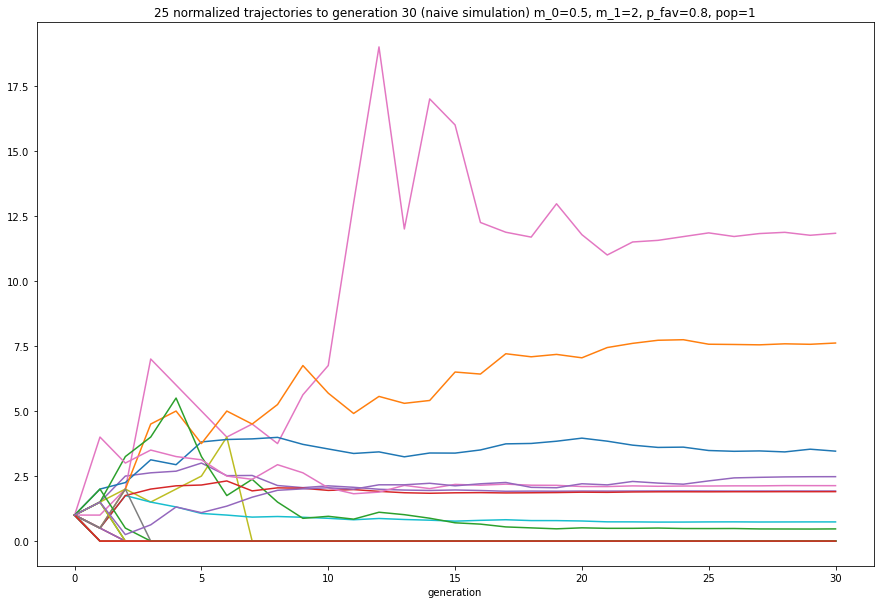

In [69]:
p_fav=0.8
m_1 = 2
m_0 = .5
normalized_trajectories_generator2(25,30)

A fonction that calculate the probability of death in a deterministic way. Warning : the runtime is exponential in n

In [70]:
import itertools

In [71]:
def proba_death(n, pop) :
    s = 0
    for i in itertools.product('01', repeat = n) :
        p=1
        q=[1]
        for j in range(n) :
            if i[j] == '1' :
                p = p*p_fav
                q.append(q[-1]/m_1)
            else :
                p = p*(1-p_fav)
                q.append(q[-1]/m_0)
        s += p*(1 - 1/(np.sum(q)))**pop
    return s

A universal Monte Carlo estimator

In [72]:
"event : event we want to estimate the probability"
"K : number of independent simulated trajectories"

def naive_MC2(event, K) :
    X = np.zeros((K, n+1))
    E=np.zeros((K, n))
    X[:,0] = K*[pop]
    for j in range(n) :
        for i in range(K) :
            A = markov2(int(X[i,j]))  #X and E have to be filled with the SAME transition
            X[i,j+1]=A[0]
            E[i,j]=A[1]
    B = [event(X[i,:]) for i in range(K)]
#    print("proba = {} (n={}, c={}, m={}, pop={})".format(np.mean(B),n,c,m,pop))
    return np.mean(B)

### Key functions

Also return the environments 

In [73]:
def trajectories2(potential) :  #we just change the Markov chain
    
    X = np.zeros((M,n+1))
    E = np.zeros((M,n))         #environnement
    X[:,0] = M*[pop]
    Z = np.zeros((M,n+1))
    F = np.zeros((M,n))
    
    C = 1
    
    for p in range(n): 
        G = potential(X[:,:p+1])
        C = C * (1./M) * np.sum(G)
        I = np.random.choice(np.arange(M), size = M, replace = True, p = G/np.sum(G))
        for j in range(M) :
            Z[j,0:(p+1)] = X[I[j],0:(p+1)]
            F[j,:p] = E[I[j],:p]
            a, b = markov2(int(Z[j,p]))
            Z[j,(p+1)] = a                    #markov2 instead of markov
            F[j,p] = b
        X = Z
        E = F
  
    return (X, C, E)

In [74]:
def proba2(event, potential) :
    [X, C] = trajectories2(potential)[0:2]       #trajectories2 instead of trajectories
    s=0
    for i in range(M) :
        if event(X[i, :]) :
            u=1
            for j in range(n-1) :
                u = u/potential(X[i, :j+2])
            s+=u
    return C*(1./M)*s

### Study of probability of survival

Text(0.5, 1.0, 'Probability of survival in function of generation(m_1=2, m_0=0.5, p_fav=0.2, pop=5, M=100)')

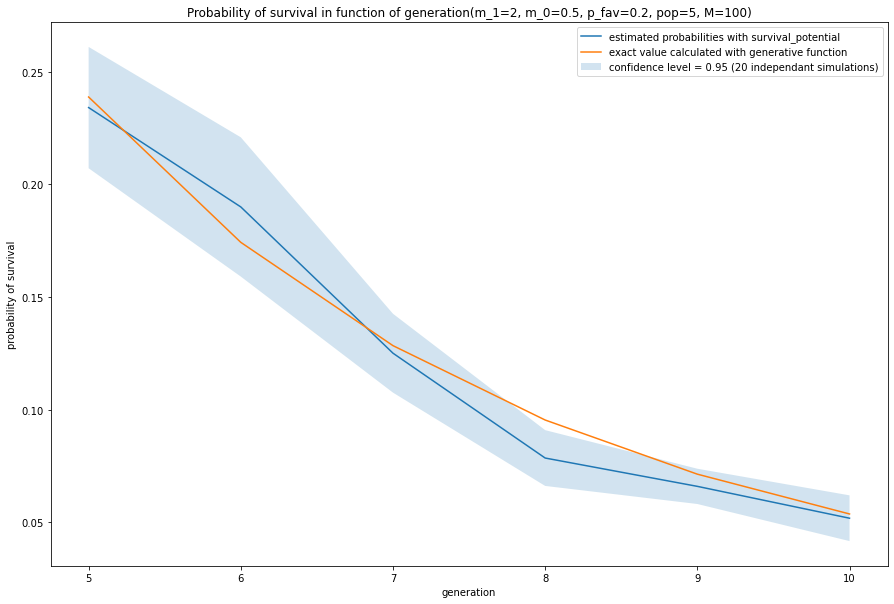

In [75]:
"parameters of the problem"
p_fav= .2
m_1=2
m_0=.5
pop=5
# not n because here the generation varies, see "parameters of the plot"

"parameters of simulation"
M=100

"parameters of the plot"

z=10            #last generation
a=5             #first generation
K=20            #number of simulations for each estimated probability
gamma = 0.95    #confidence level

"core of the program"

list_prob=[]      #list of estimated probabilities
list_sup=[]
list_inf=[]
X=[]
for i in range(a,z+1):
    n=i                   #modification of the global parameter n
    X=[]
    for _ in range(K) :
        X.append(proba2(survival, survival_potential))
    A = confidence(X, gamma)
    list_prob.append(A[0])
    list_sup.append(A[1][1])
    list_inf.append(A[1][0])
    

fig, ax = plt.subplots()
ax.plot(range(a,z+1), list_prob, '-', label ="estimated probabilities with survival_potential")
ax.fill_between(range(a,z+1), list_inf, list_sup, alpha=0.2, 
                label="confidence level = {} ({} independant simulations)".format(gamma, K))

if z<12 :
    plt.plot(range(a,z+1),[1.0-proba_death(i,pop) for i in range(a,z+1)], 
         label="exact value calculated with generative function")
plt.xlabel("generation")
plt.ylabel("probability of survival")
plt.legend(loc='best')
plt.title("Probability of survival in function of generation"
          "(m_1={}, m_0={}, p_fav={}, pop={}, M={})".format(m_1,m_0,p_fav,pop,M))

### Generation of typical scenarii

First a naive simulator of SURVIVAL scenarii

In [76]:
def scenarii2_naive(K) :   #K number of desired scenarii
    X = np.zeros((M, n+1))
    E = np.zeros((M,n))
    X[:,0] = M*[pop]
    for j in range(n) :
        for i in range(M) :
            A = markov2(int(X[i,j]))
            X[i,j+1]=A[0]
            E[i,j]=A[1]
    Y=X[X[:, -1]>0]  
    E=E[X[:, -1]>0]
    
    plt.close(1)
    plt.figure(1)
    for i in range(K) :
        plt.plot(np.arange(n+1),Y[i, :], linewidth=1.5)
    plt.title("{} survival scenarii to generation {} (naive simulation) "
                    "m_0={}, m_1={}, p_fav={}, pop={}, M={}".format(K,n,m_0,m_1,p_fav,pop,M))
    plt.legend(loc='best')
    plt.xlabel("generation")
    plt.ylabel("value of X_n")
    
    plt.close(2)
    plt.figure(2)
    for i in range(K) :
        plt.plot(np.arange(n),np.cumsum(E[i, :]))
    plt.plot(np.arange(0,n,0.01),[p_fav*x for x in np.arange(0,n,0.01)],label="expected knowing p_fav")
    plt.title("Cumulative number of favorable environnments in fonction of generation \n"
              "{} scenarii of survival to generation {} (naive simulation) "
                    "m_0={}, m_1={}, p_fav={}, pop={}, M={}".format(K,n,m_0,m_1,p_fav,pop,M))
    plt.legend(loc='upper left')
    plt.xlabel("generation")
    plt.ylabel("cumulative number of favorable environnments")
    
    plt.close(3)
    plt.figure(3)
    
    Z = np.sum(E[:K,:] ,axis=1)
    Y = [int(x) for x in Z]
    counts = np.bincount(Y, minlength=n+1)
    counts = counts / K
    
    p_emp = np.mean(Y)/n
    print("empirical probability to have favorable environnment={}".format(p_emp))
    
    plt.bar(np.arange(0, 1+1./(2*n), 1./n), counts, width = 1./(4*n), color = 'r',
            label="empirical distribution of the proportion of favorable environnments")
    plt.bar(np.arange(0, 1 + 1./(2*n), 1./n)+1./(4*n), [sps.binom.pmf(k,n,p_emp) for k in range(n+1)], 
            width = 1./(4*n), color = 'b',
           label = "binomial distribution with the same mean")
    plt.title("distribution of the proportion of favorable environnments at generation {} "
              "conditionned to survival (naive simulation) \n"
              "m_0={}, m_1={}, p_fav={}, pop={}, M={}".format(n,m_0,m_1,p_fav,pop,M))
    plt.axvline(x=p_fav, color="g",linewidth=1.5, label="expected = p_fav")
    plt.legend(loc='best')

No handles with labels found to put in legend.


empirical probability to have favorable environnment=0.39


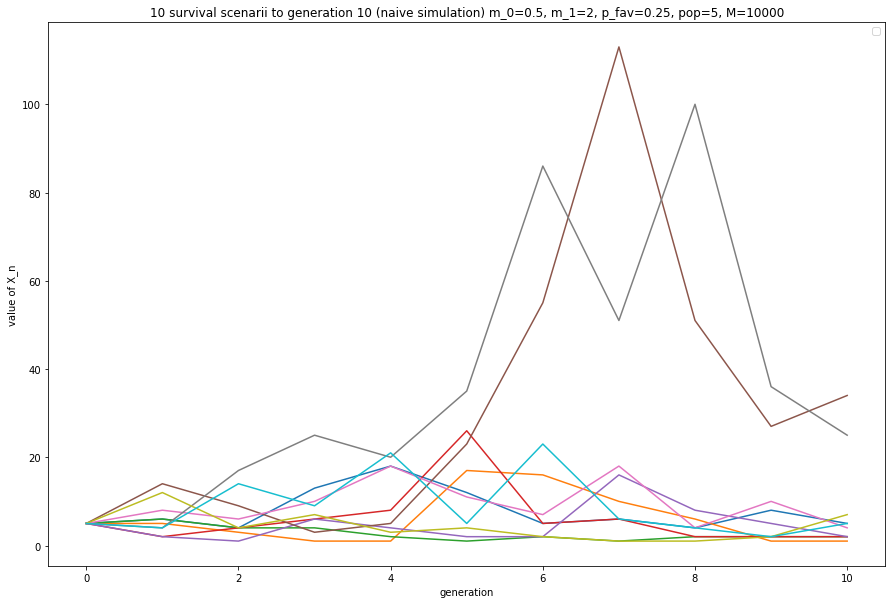

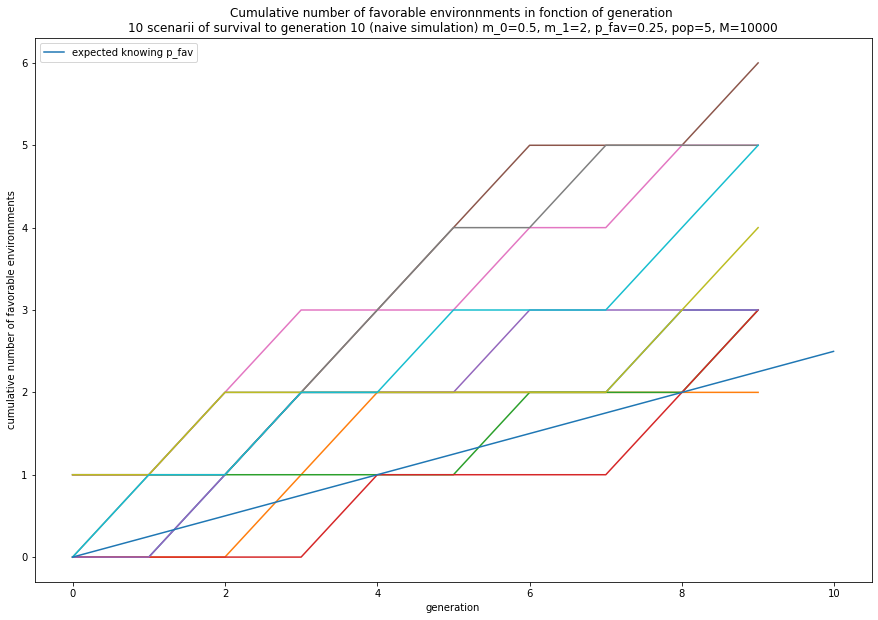

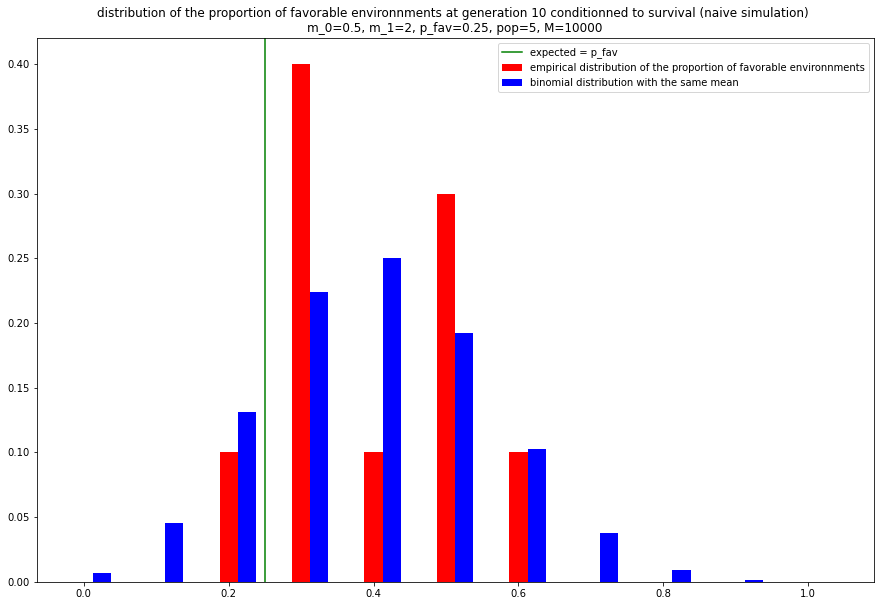

In [77]:
n=10
p_fav=0.25
m_0 = 0.5
m_1=2
M=10000
scenarii2_naive(10)

Then a generator using survival_potential

In [78]:
def scenarii2(K) : # K number of scenarii
    A =trajectories2(survival_potential)
    X=A[0]
    E=A[2]
    Y=X[X[:, -1]>0]
    E=E[X[:, -1]>0]
    
    plt.close(1)
    plt.figure(1)
    for i in range(K) :
        plt.plot(np.arange(n+1),Y[i, :], linewidth=1.5)
    plt.title("{} survival scenarii to generation {} (simulation with survival_potential) "
                    "m_0={}, m_1={}, p_fav={}, pop={}, M={}".format(K,n,m_0,m_1,p_fav,pop,M))
    plt.legend(loc='best')
    plt.xlabel("generation")
    plt.ylabel("value of X_n")
    
    plt.close(2)
    plt.figure(2)
    for i in range(K) :
        plt.plot(np.arange(n),np.cumsum(E[i, :]))
    plt.plot(np.arange(0,n,0.01),[p_fav*x for x in np.arange(0,n,0.01)],label="expected knowing p_fav")
    plt.title("Cumulative number of favorable environnments in fonction of generation \n"
              "{} scenarii of survival to generation {} (simulation with survival_potential) "
                    "m_0={}, m_1={}, p_fav={}, pop={}, M={}".format(K,n,m_0,m_1,p_fav,pop,M))
    plt.legend(loc='upper left')
    plt.xlabel("generation")
    plt.ylabel("cumulative number of favorable environnments")
    
    plt.close(3)
    plt.figure(3)
    
    Z = np.sum(E[:K,:] ,axis=1)
    Y = [int(x) for x in Z]
    counts = np.bincount(Y, minlength=n+1)
    counts = counts / K
    
    p_emp = np.mean(Y)/n
    print("empirical probability to have favorable environnment={}".format(p_emp))
    
    plt.bar(np.arange(0, 1+1./(2*n), 1./n), counts, width = 1./(4*n), color = 'r',
            label="empirical distribution of the proportion of favorable environnments")
    plt.bar(np.arange(0, 1 + 1./(2*n), 1./n)+1./(4*n), [sps.binom.pmf(k,n,p_emp) for k in range(n+1)], 
            width = 1./(4*n), color = 'b',
           label = "binomial distribution with the same mean")
    plt.title("distribution of the proportion of favorable environnments at generation {} "
              "conditionned to survival (simulation with survival_potential) \n"
              "m_0={}, m_1={}, p_fav={}, pop={}, M={}".format(n,m_0,m_1,p_fav,pop,M))
    plt.axvline(x=p_fav, color="g",linewidth=1.5, label="expected = p_fav")
    plt.legend(loc='best')

No handles with labels found to put in legend.


empirical probability to have favorable environnment=0.385


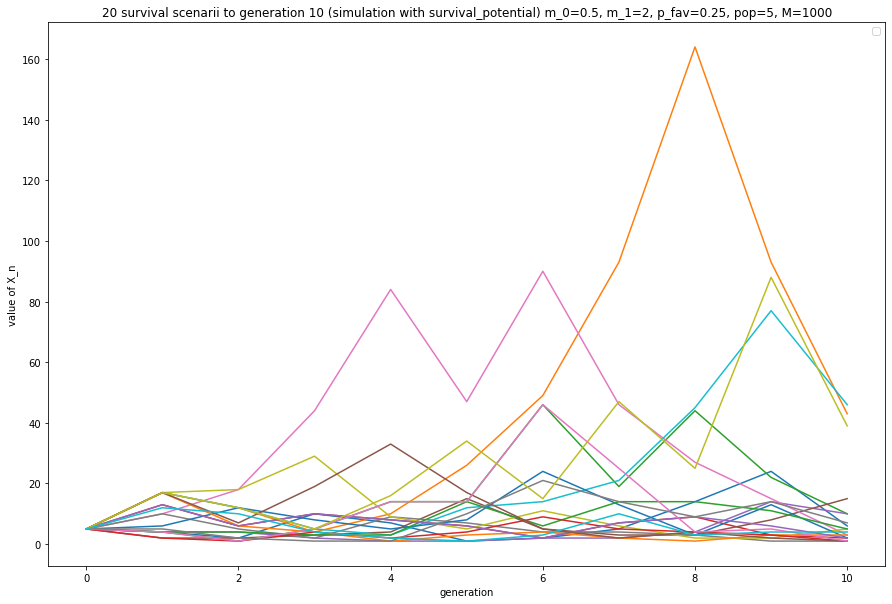

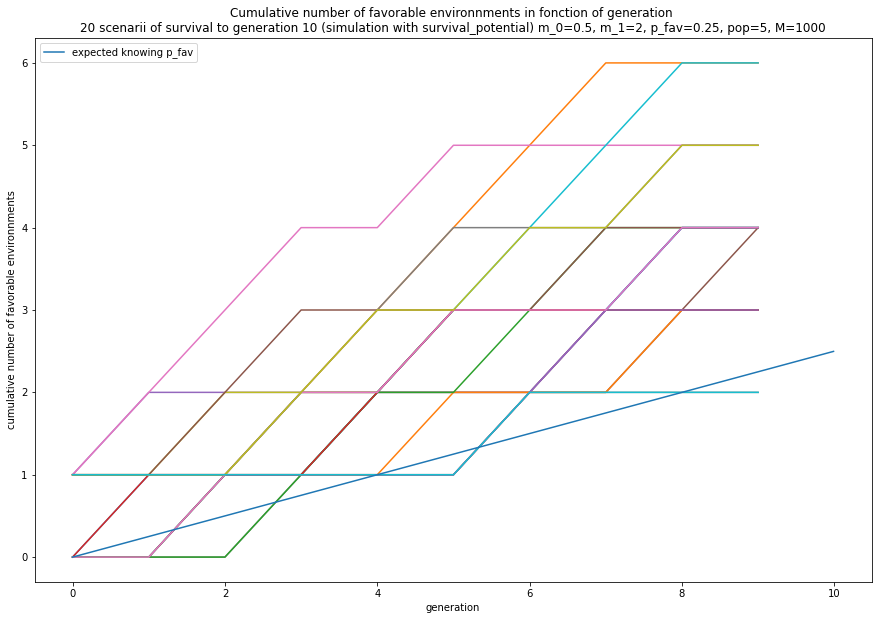

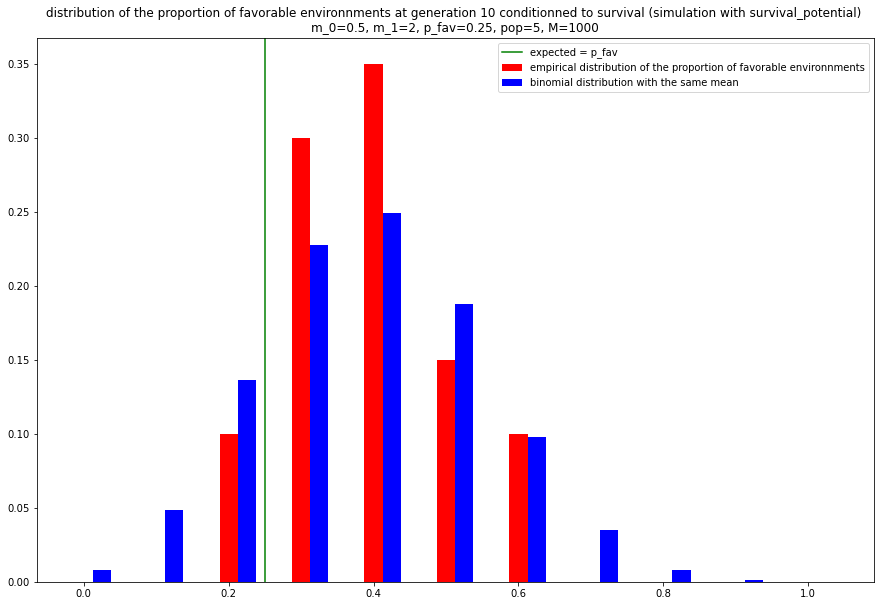

In [79]:
n=10
M=1000
p_fav=0.25
m_0 = 0.5
m_1=2
scenarii2(20)

A naive simulator for UNDERGROWTH scenarii

In [80]:
def scenarii2_ug_naive(K) :  #K number of scenarii
    X = np.zeros((M, n+1)) 
    E = np.zeros((M,n))
    X[:,0] = M*[pop]
    for j in range(n) :
        for i in range(M) :
            A = markov2(int(X[i,j]))
            X[i,j+1]=A[0]
            E[i,j]=A[1]
    B = [undergrowth(X[i, :]) for i in range(M)]
    X=X[B]
    E=E[B]

    plt.close(1)
    plt.figure(1)
    for i in range(K) :
        plt.plot(np.arange(n+1),X[i, :], linewidth=1.5)
    plt.plot(np.arange(0,n+0.1,0.1), [c**x for x in np.arange(0,n+0.1,0.1)], label='limite of undergrowth')
    plt.title("{} undergrowth scenarii to generation {} (naive simulation) "
                    "m_0={}, m_1={}, p_fav={}, c={}, pop={}, M={}".format(K,n,m_0,m_1,p_fav,c,pop,M))
    plt.legend(loc='best')
    plt.xlabel("generation")
    plt.ylabel("value of X_n")
    
    plt.close(2)
    plt.figure(2)
    for i in range(K) :
        plt.plot(np.arange(n),np.cumsum(E[i, :]))
    plt.plot(np.arange(0,n,0.01),[p_fav*x for x in np.arange(0,n,0.01)],label="expected knowing p_fav")
    plt.title("Cumulative number of favorable environnments in fonction of generation \n"
              "{} scenarii of undergrowth to generation {} (naive simulation) "
                    "m_0={}, m_1={}, p_fav={}, c={}, pop={}, M={}".format(K,n,m_0,m_1,p_fav,c,pop,M))
    plt.legend(loc='upper left')
    plt.xlabel("generation")
    plt.ylabel("cumulative number of favorable environnments")
    
    plt.close(3)
    plt.figure(3)
    
    Z = np.sum(E[:K,:] ,axis=1)
    Y = [int(x) for x in Z]
    counts = np.bincount(Y, minlength=n+1)
    counts = counts / K
    
    p_emp = np.mean(Y)/n
    print("empirical probability to have favorable environnment={}".format(p_emp))
    
    plt.bar(np.arange(0, 1+1./(2*n), 1./n), counts, width = 1./(4*n), color = 'r',
            label="empirical distribution of the proportion of favorable environnments")
    plt.bar(np.arange(0, 1 + 1./(2*n), 1./n)+1./(4*n), [sps.binom.pmf(k,n,p_emp) for k in range(n+1)], 
            width = 1./(4*n), color = 'b',
           label = "binomial distribution with the same mean")
    plt.title("distribution of the proportion of favorable environnments at generation {} "
              "conditionned to undergrowth (naive simulation) \n"
              "m_0={}, m_1={}, p_fav={}, pop={}, M={}".format(n,m_0,m_1,p_fav,pop,M))
    plt.axvline(x=p_fav, color="g",linewidth=1.5, label="expected = p_fav")
    plt.legend(loc='best')

empirical probability to have favorable environnment=0.26


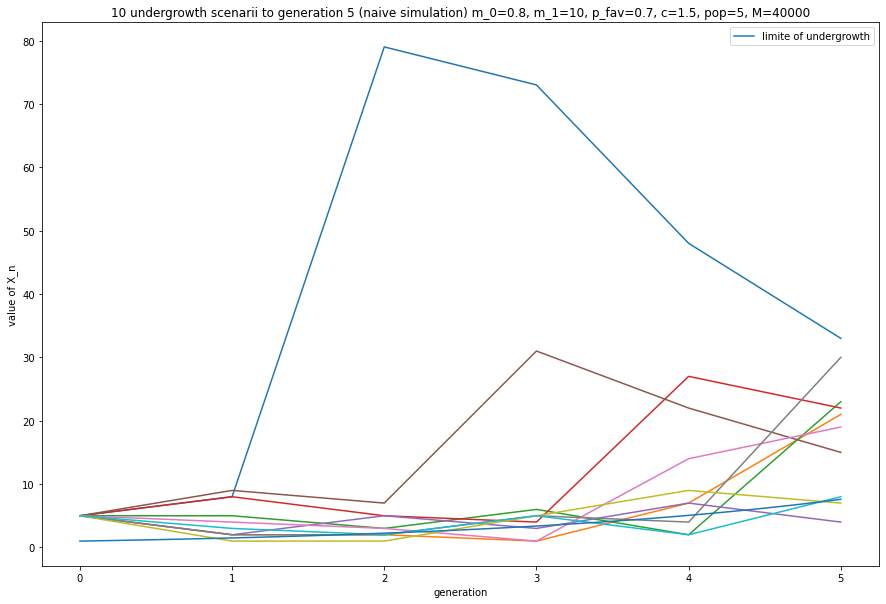

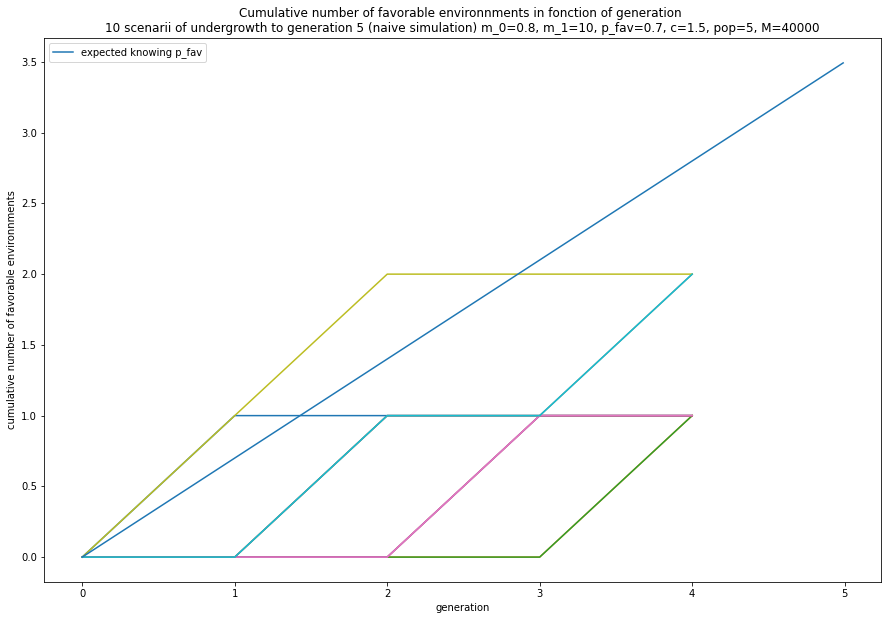

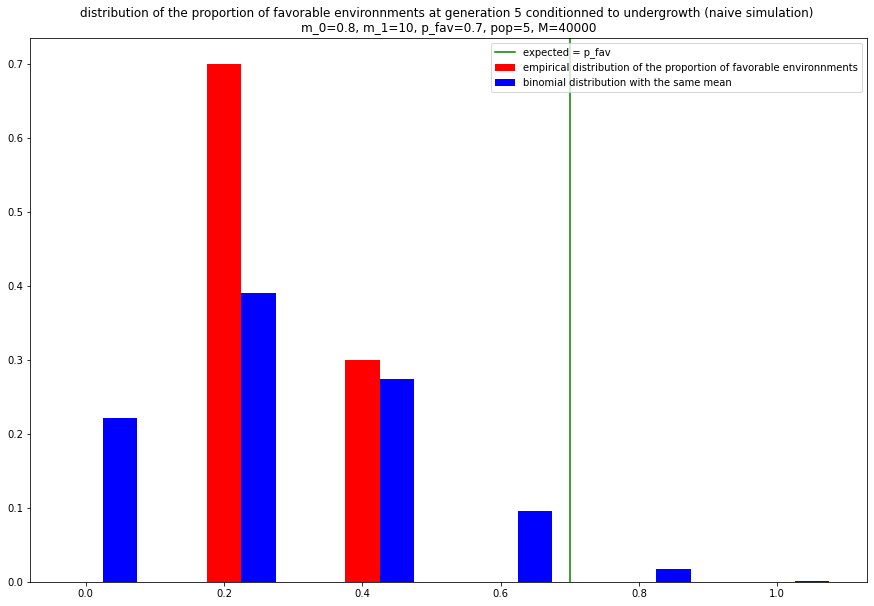

In [81]:
n=5
m_0=0.8
m_1=10
p_fav=0.7
M=40000
c=1.5
scenarii2_ug_naive(10)

Now, using log_log_potential

In [82]:
def scenarii_ug2(K, potential) : #K number of scenarii
    A =trajectories2(potential)
    X = A[0]
    E = A[2]
    B = [undergrowth(X[i, :]) for i in range(M)]
    u = np.sum(B)
    X=X[B]
    
    W = u*[0]
    for i in range(u) :
        r = 1
        for j in range(n-1) :
            r = r*potential(X[i, :j+2])
        W[i] = 1/r
        
    I = np.random.choice(np.arange(u), size = K, replace = False, p = W/np.sum(W))
    
    plt.close(1)
    plt.figure(1)
    for i in range(K) :
        plt.plot(np.arange(n+1),X[i, :], linewidth=1.5)
    plt.title("{} survival scenarii to generation {} (simulation with log_log_potential) "
                    "m_0={}, m_1={}, p_fav={}, c={}, pop={}, M={}".format(K,n,m_0,m_1,p_fav,c,pop,M))
    plt.plot(np.arange(0,n+0.1,0.1), [c**x for x in np.arange(0,n+0.1,0.1)], label='limite of undergrowth')
    plt.legend(loc='best')
    plt.xlabel("generation")
    plt.ylabel("value of X_n")
    
    plt.close(2)
    plt.figure(2)
    for i in range(K) :
        plt.plot(np.arange(n),np.cumsum(E[i, :]))
    plt.plot(np.arange(0,n,0.01),[p_fav*x for x in np.arange(0,n,0.01)],label="expected knowing p_fav")
    plt.title("Cumulative number of favorable environnments in fonction of generation \n"
              "{} scenarii of survival to generation {} (simulation with log_log_potential) "
                    "m_0={}, m_1={}, p_fav={}, c={}, pop={}, M={}".format(K,n,m_0,m_1,p_fav,c,pop,M))
    plt.legend(loc='upper left')
    plt.xlabel("generation")
    plt.ylabel("cumulative number of favorable environnments")
    
    plt.close(3)
    plt.figure(3)
    
    Z = np.sum(E[:K,:] ,axis=1)
    Y = [int(x) for x in Z]
    counts = np.bincount(Y, minlength=n+1)
    counts = counts / K
    
    p_emp = np.mean(Y)/n
    print("empirical probability to have favorable environnment={}".format(p_emp))
    
    plt.bar(np.arange(0, 1+1./(2*n), 1./n), counts, width = 1./(4*n), color = 'r',
            label="empirical distribution of the proportion of favorable environnments")
    plt.bar(np.arange(0, 1 + 1./(2*n), 1./n)+1./(4*n), [sps.binom.pmf(k,n,p_emp) for k in range(n+1)], 
            width = 1./(4*n), color = 'b',
           label = "binomial distribution with the same mean")
    plt.title("distribution of the proportion of favorable environnments at generation {} "
              "conditionned to survival (simulation with log_log_potential) \n"
              "m_0={}, m_1={}, p_fav={}, pop={}, c={}, M={}".format(n,m_0,m_1,p_fav,pop,c,M))
    plt.axvline(x=p_fav, color="g",linewidth=1.5, label="expected = p_fav")
    plt.legend(loc='best')

empirical probability to have favorable environnment=0.64


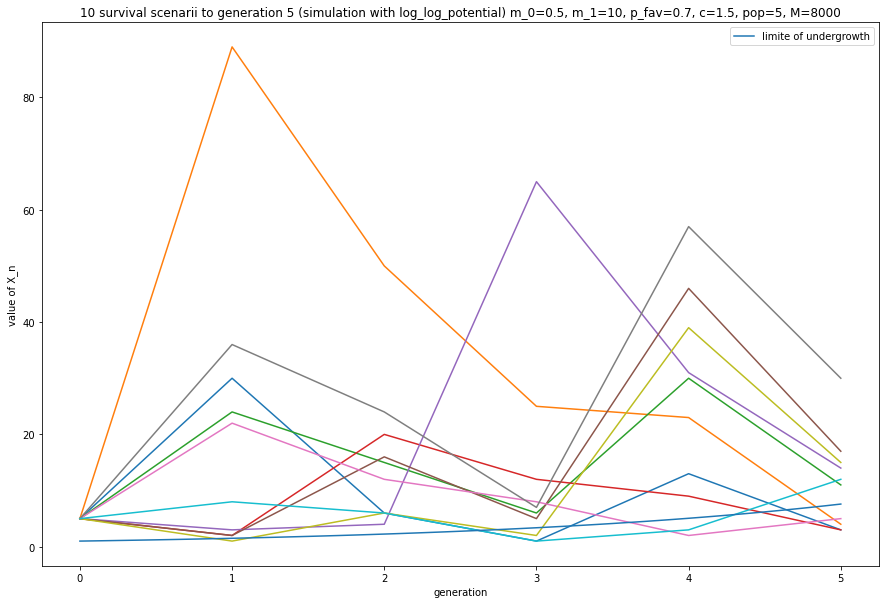

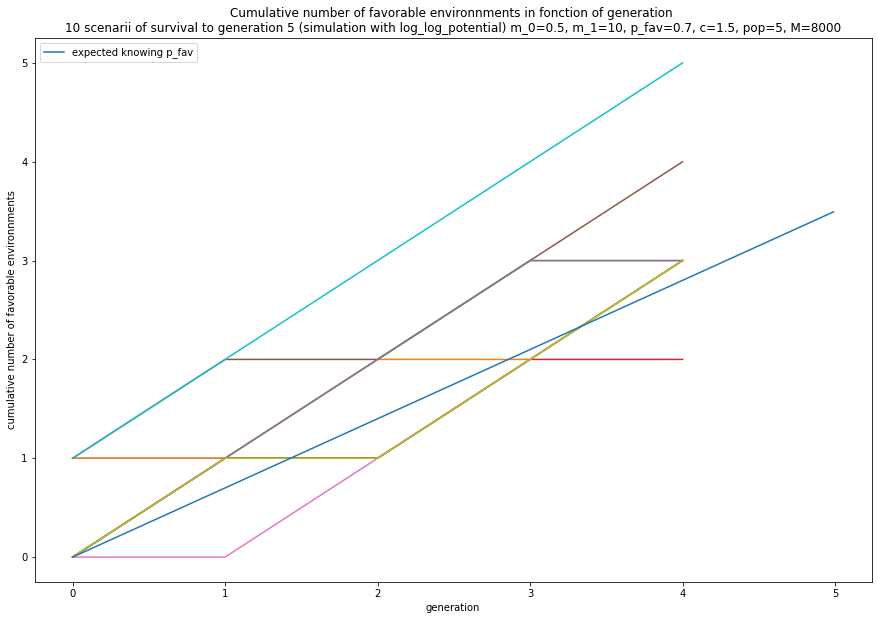

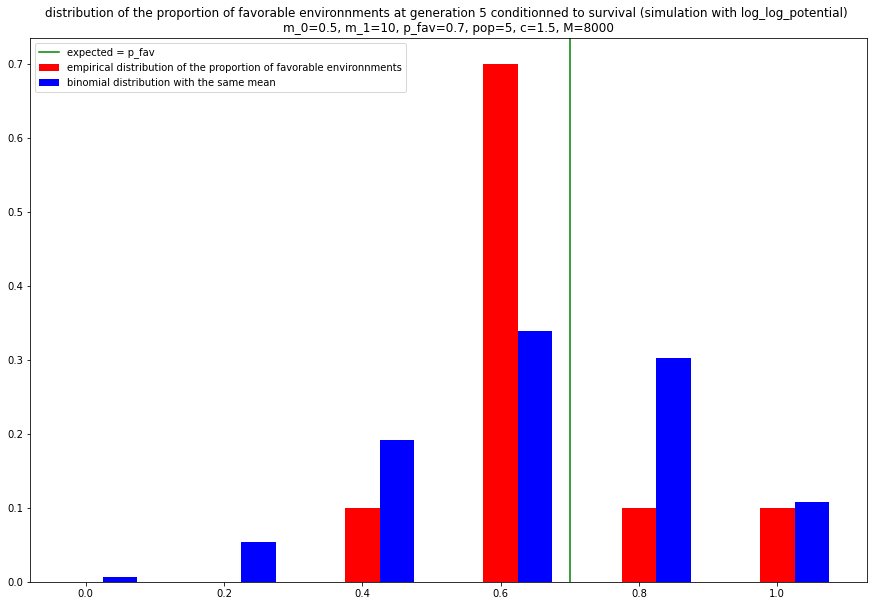

In [83]:
n=5
m_0=0.5
m_1=10
p_fav=0.7
M=8000
c=1.5
scenarii_ug2(10, log_log_potential)